In [3]:
%matplotlib notebook
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import scipy
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d as gf1d
from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import uniform_filter as uf
from skimage.transform import downscale_local_mean #For binning

import xarray as xr #package for labeling and adding metadata to multi-dimensional arrays

import sys
sys.path.append("../kai_colloids/PyDDM") #must point to the PyDDM folder
import ddm_analysis_and_fitting as ddm

import tiff_file
import ddm_clean 

import io 
import sys
import csv

import os
import glob #glob is helpful for searching for filenames or directories
import pickle #for saving data

## Image autocorrelation function defined below

In [18]:
def im_corr(im, filter=False, filtersize=80, bin=True, binsize=2):
    ''' Computes image autocorrelation. 
    Takes as input:
        image: 2D image
        filter: Boolean, if true will filter image with uniform filter
        filtersize: size for uniform filtering
    Returns:
        corr_im: the image autocorrelation (this will be same size as image)
        rav_corr: radially averaged image autocorrelation '''
    # Crop image
    #image = im[:1440, :1440]
        
    if bin:
        image = downscale_local_mean(image, (binsize,binsize), cval=1)
        
    if filter:
        image = image*1.0 - uf(image,filtersize)
    image = 1.0*image-image.mean() #subtract mean
    image = image/image.std() #normalize by standard deviation
    corr_im = abs(fftshift(ifft2(fft2(image)*np.conj(fft2(image)))))/(image.shape[0]*image.shape[1])
    
    #radial average taken
    rav_corr = ddm_clean.newRadav(corr_im)
    
    #return ONLY rav_corr **b/c I don't need corr_im** (CHANGE THIS IF YOU DO) 
    return rav_corr

###not sure if this function is necessary
def filtimage(image, filtersize=80):
    image = image*1.0 - uf(image,filtersize)
    return image

###define the double exponential we use to fit SIA curves
def double_exponential(x, A, B, l1, l2):
    return (A*np.exp(-x/l1)) + (B*np.exp(-x/l2))

def single_exponential(x, As, ls):
    return (As*np.exp(-x/ls)) 

def if_single_exp(popt):
    if popt[1] == 0:
        single_popt = [popt[0], popt[2]]
        fit_values = single_exponential(x_fit_values, *single_popt)
        return fit_values
    else:
        fit_values = double_exponential(x_fit_values, *popt)
        return fit_values

###define function to systimatically reduce the fit length until the fit parameters meet the specific criteria
def check_fits(A, B, l1, l2, y_array, retry_num):
    if A == br_A:
        row = "(br) "
    elif A == mr_A:
        row = "(mr) "
    else:
        row = "(tr) "
    j=1
    skip_to_next = 0
    if (A < 0.049) or (B < 0.049) or (l1 > 135.0) or (l2 > 135.0): ##this line sets the specific criteria for fit params to meet
        try_again = True
        print("     poor fit at "+row+ time)
        while try_again:
            new_fit_lim = fit_lim - ((2*j))
            x_fit_lim = all_xvalues[new_fit_lim]
            try:
                popt, pcov = curve_fit(double_exponential, all_xvalues[0:new_fit_lim], y_array[0:new_fit_lim], 
                                   p0 = [0.5,0.5,4.0,30.0])
            except RuntimeError:
                print("RuntimeError - curve_fit failed")
                skip_to_next = 1
            print("        "+row+time+"-- xlim= "+str(x_fit_lim)+', fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(popt))
            A, B, l1, l2 = tuple(popt)
            x_fit_values = np.linspace(all_xvalues[1], all_xvalues[new_fit_lim], 1000)
            if (j == (retry_num-1)) or ((np.abs(l2 - l1)) < 0.1):
                print("   poor fit at "+row+ time + " --> try single exponential fit")
                try_again = False
                try_single = True
                i = 0
                while try_single:
                    new_fit_lim = fit_lim - (2*i)
                    x_fit_lim = all_xvalues[new_fit_lim]
                    popt, pcov = curve_fit(single_exponential, all_xvalues[0:new_fit_lim], y_array[0:new_fit_lim], 
                                           p0 = [0.5,7.0])
                    print("           "+row+time+"-- xlim= "+str(x_fit_lim)+', fit: As=%5.3f, ls=%5.3f' % tuple(popt))
                    As, ls = tuple(popt)
                    x_fit_values = np.linspace(all_xvalues[1], all_xvalues[new_fit_lim], 1000)
                
                    if i == retry_num:
                        print("           poor fit at "+row+ time + " can't be fixed :(")
                        try_again = False
                        x_fit_lim = all_xvalues[fit_lim]
                        x_fit_values = np.linspace(all_xvalues[1], all_xvalues[fit_lim], 1000)
                        A, B, l1, l2 =  0, 0, 0, 0
                        #return A, B, l1, l2, popt
                    elif (As < 0.1) or (ls > 135.0):
                        try_again = True
                        i = i+1
                    else:
                        try_single = False
                        print("       yay!! good fit at "+row+time)
                        print("       "+row+time+"-- xlim= "+str(x_fit_lim)+', fit: As=%5.3f, ls=%5.3f' % tuple(popt))
                        A, B, l1, l2 =  As, 0, ls, 0
                        #return A, B, l1, l2, popt
            elif (A < 0.049) or (B < 0.049) or (l1 > 135.0) or (l2 > 135.0) or (skip_to_next == 1):
                try_again = True
                skip_to_next = 0
                j = j+1
            else:
                try_again = False
                print("  yay!! good fit at "+row+time)
                print("  "+row+time+"-- xlim= "+str(x_fit_lim)+', fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(popt))
    return [A, B, l1, l2]

def avg_and_std_error(tup_key, br_array, mr_array, tr_array, avg_array, stderror_array):
    for i in range(len(br_array)):
        if (br_array[i][tup_key]!=0) and (mr_array[i][tup_key]!=0) and (tr_array[i][tup_key]!=0):
            avg_array[i] = (br_array[i][tup_key] + mr_array[i][tup_key] +tr_array[i][tup_key])/3
            stderror_array[i] = (np.sqrt((((br_array[i][tup_key]-avg_array[i])**2)+((mr_array[i][tup_key]-avg_array[i])**2)
                                       +((tr_array[i][tup_key]-avg_array[i])**2))/3))/np.sqrt(3)

        elif (br_array[i][tup_key]==0) and (mr_array[i][tup_key]!=0) and (tr_array[i][tup_key]!=0):
            avg_array[i] = (mr_array[i][tup_key] + tr_array[i][tup_key])/2 
            stderror_array[i] = (np.sqrt((((mr_array[i][tup_key]-avg_array[i])**2) 
                                          +((tr_array[i][tup_key]-avg_array[i])**2))/2))/np.sqrt(2)

        elif (mr_array[i][tup_key]==0) and (br_array[i][tup_key]!=0) and (tr_array[i][tup_key]!=0):
            avg_array[i] = (br_array[i][tup_key] + tr_array[i][tup_key])/2
            stderror_array[i] = (np.sqrt((((br_array[i][tup_key]-avg_array[i])**2) 
                                          +((tr_array[i][tup_key]-avg_array[i])**2))/2))/np.sqrt(2)

        elif (tr_array[i][tup_key]==0) and (br_array[i][tup_key]!=0) and (mr_array[i][tup_key]!=0):
            avg_array[i] = (br_array[i][tup_key] + mr_array[i][tup_key])/2
            stderror_array[i] = (np.sqrt((((br_array[i][tup_key]-avg_array[i])**2) 
                                          +((mr_array[i][tup_key]-avg_array[i])**2))/2))/np.sqrt(2)
        
        elif (br_array[i][tup_key]==0) and (mr_array[i][tup_key]==0):
            avg_array[i] = tr_array[i][tup_key]
            stderror_array[i] = 0
        elif (mr_array[i][tup_key]==0) and (tr_array[i][tup_key]==0):
            avg_array[i] = br_array[i][tup_key]
            stderror_array[i] = 0
        elif (br_array[i][tup_key]==0 and tr_array[i][tup_key]==0):
            avg_array[i] = mr_array[i][tup_key]
            stderror_array[i] = 0

def check_A_B_sum(br_A, br_B, mr_A, mr_B, tr_A, tr_B):
    if ((br_A + br_B) != 1.0):
        print("------> WTF? br_A + br_B = "+str((br_A + br_B)))
    elif ((mr_A + mr_B) != 1.0):
        print("------> WTF? mr_A + mr_B = "+str((mr_A + mr_B)))
    elif ((tr_A + tr_B) != 1.0):
        print("------> WTF? tr_A + tr_B = "+str((tr_A + tr_B)))
        
def choose_cmap(key_num):
    while key_num == 0:
        cmap_color = 'Reds'
    while key_num == 1:
        cmap_color = 'Blues'
    while key_num == 2:
        cmap_color = 'Greens'
    while key_num == 3:
        cmap_color = 'Greys'

In [5]:
###################################################################################
# Specify where the data is and file name for image (or image sequence)           #
###################################################################################

directory = "Z"
exp = "9-5-22_s2_theBigOne"
data_dir = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\all tiff files\\" 
data_dir2 = directory+":\\Gregor L\\__Kai Colloids\\"+exp+"\\reordered tiffs\\" #bottom_row_t01\\
plot_saveto= directory+":\\Gregor L\\__Kai Colloids\\SIA\\Data\\"+exp+"\\"

files = glob.glob(data_dir+"*_t*")
#files = sorted(files, key = last_3chars)
print("found %i files" % len(files))
print(int((len(files))/3))
for i,f in enumerate(files): print (' %i \t %s' % (i, f.split('\\')[-1]))

found 36 files
12
 0 	 row1_t01.tif
 1 	 row1_t02.tif
 2 	 row1_t03.tif
 3 	 row1_t04.tif
 4 	 row1_t05.tif
 5 	 row1_t06.tif
 6 	 row1_t07.tif
 7 	 row1_t08.tif
 8 	 row1_t09.tif
 9 	 row1_t10.tif
 10 	 row1_t11.tif
 11 	 row1_t12.tif
 12 	 row2_t01.tif
 13 	 row2_t02.tif
 14 	 row2_t03.tif
 15 	 row2_t04.tif
 16 	 row2_t05.tif
 17 	 row2_t06.tif
 18 	 row2_t07.tif
 19 	 row2_t08.tif
 20 	 row2_t09.tif
 21 	 row2_t10.tif
 22 	 row2_t11.tif
 23 	 row2_t12.tif
 24 	 row3_t01.tif
 25 	 row3_t02.tif
 26 	 row3_t03.tif
 27 	 row3_t04.tif
 28 	 row3_t05.tif
 29 	 row3_t06.tif
 30 	 row3_t07.tif
 31 	 row3_t08.tif
 32 	 row3_t09.tif
 33 	 row3_t10.tif
 34 	 row3_t11.tif
 35 	 row3_t12.tif


In [6]:
###### # specify each condition (frame_names) and the time points of data collection (time_array) #
############################################################################################
frame_names = ["1-3 kA-WT", "WT (no kA)", "EA KaiC", "AE KaiC"]
time_array =  [1, 3.83, 6.83, 10.17, 13.08, 18, 21.92, 25.25, 28.67, 45.92, 49.33, 69.42]
#[0.5, 4.5, 8, 12, 20, 24]
#[0.5, 3.5, 6.5, 9.3, 12.1, 15, 18, 21, 24.5, 27.3, 40.5, 44.3]  
#[0.5, 3.2, 17.75, 20, 22, 24.25, 26, 41.75, 44]
#[0.85, 3.5, 18, 20.4, 22.25, 24.5, 26.2, 41.75, 44.2]
#s1 [0.67, 3.67, 6.67, 10, 12.83, 17.67, 21.67, 24.92, 28.17, 45.67, 49.08, 69.25]
#s2 [1, 3.83, 6.83, 10.17, 13.08, 18, 21.92, 25.25, 28.67, 45.92, 49.33, 69.42]
fig_size = 10,10/1.618
font_size = 16
dpi_num = 800
pixel_size = 0.364 # 4*0.091 = 0.364

print((files[0]))
eg_im= tiff_file.imread(files[0])
print(eg_im.shape)
frames_per_tiff = int(eg_im.shape[0])
print(frames_per_tiff)
arr_length = int((len(files))/3)
print(arr_length)

Z:\Gregor L\__Kai Colloids\9-5-22_s2_theBigOne\all tiff files\row1_t01.tif


C:\Users\gleech\Documents\GitHub\kai codes\kai_colloids\tiff_file.py:724: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = numpy.vstack((p.asarray() if p else nopage)


(5, 1440, 1920)
5
12


<IPython.core.display.Javascript object>


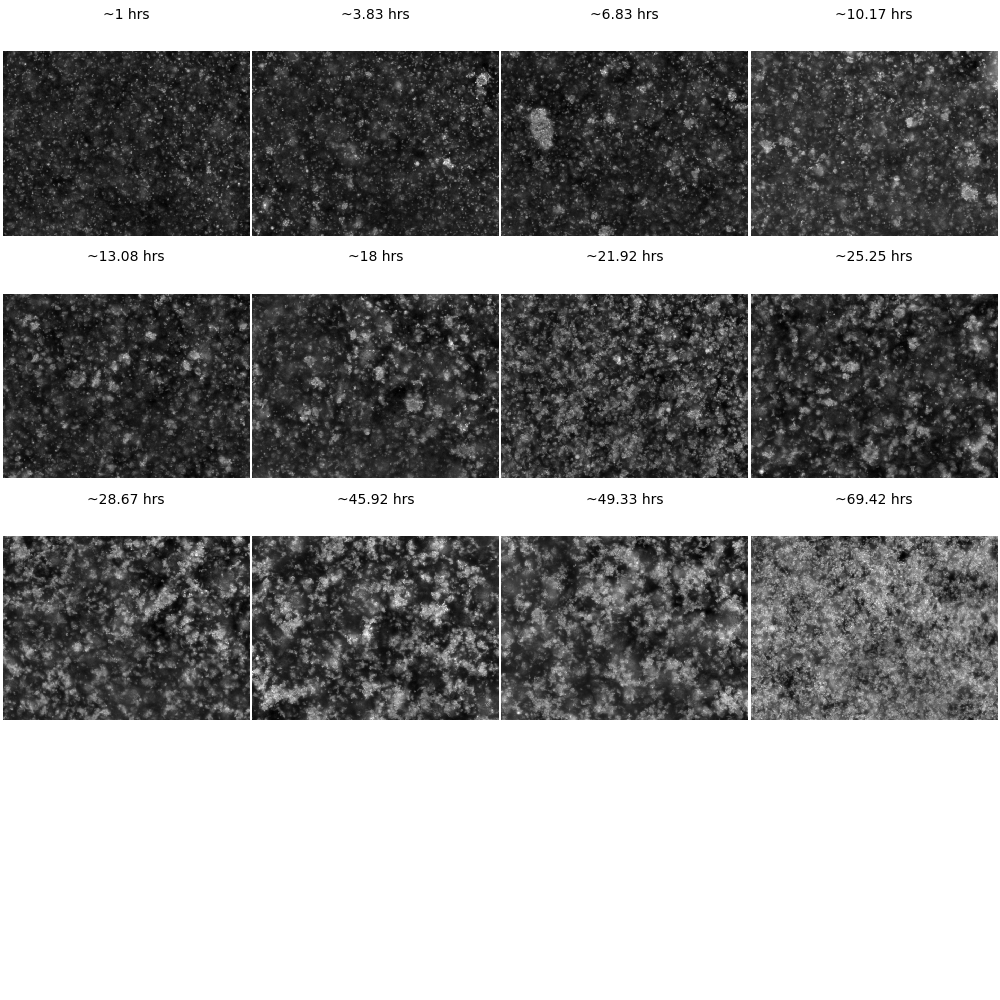

In [40]:
fig = plt.figure(figsize=(10,10))    #figsize=(10,10)
for i in range (arr_length):
    ax = plt.subplot(4,4,i+1) ##change according to number of frames (6 --> 3,3; 12 --> 4,4)
    ax.set_title("~" + str(time_array[i]) + " hrs", fontsize=10)
    test_image = tiff_file.imread(files[i],key=[0])
    
    filtered_image = filtimage(test_image, filtersize=700)
    fully_processed_image = downscale_local_mean(filtered_image, (2,2), cval=1)
    ax.matshow(fully_processed_image, cmap = 'gray')
    #ax.matshow(test_image, cmap = 'gray')
    plt.axis('off')
    plt.tight_layout(pad=.2)

<IPython.core.display.Javascript object>


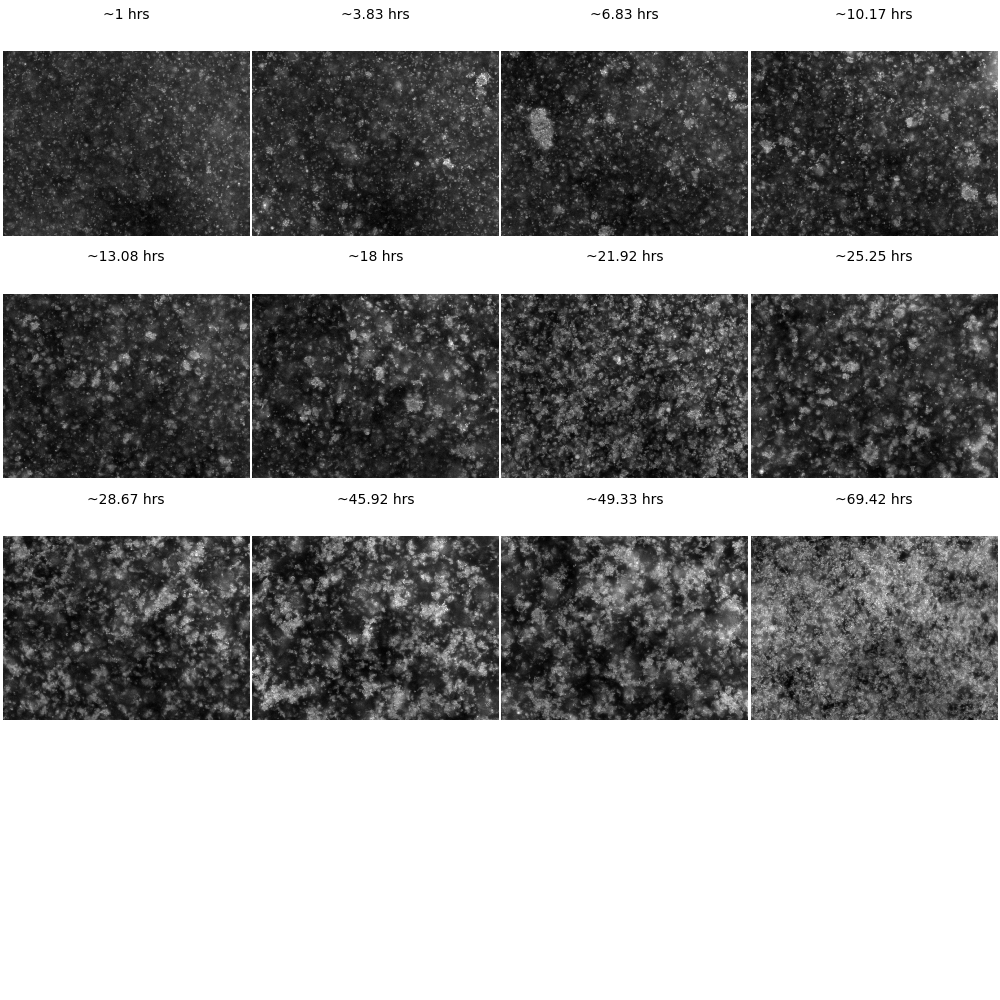

In [42]:
fig = plt.figure(figsize=(10,10))    #figsize=(10,10)
for i in range (arr_length):
    ax = plt.subplot(4,4,i+1) ##change according to number of frames (6 --> 3,3; 12 --> 4,4)
    ax.set_title("~" + str(time_array[i]) + " hrs", fontsize=10)
    test_image = tiff_file.imread(files[i],key=[0])
    
    binned_image = downscale_local_mean(test_image, (2,2), cval=1)
    fully_processed_image = filtimage(binned_image, filtersize=500)
    #ax.matshow(fully_processed_image, cmap = 'gray')
    ax.matshow(test_image, cmap = 'gray')
    plt.axis('off')
    plt.tight_layout(pad=.2)

<IPython.core.display.Javascript object>


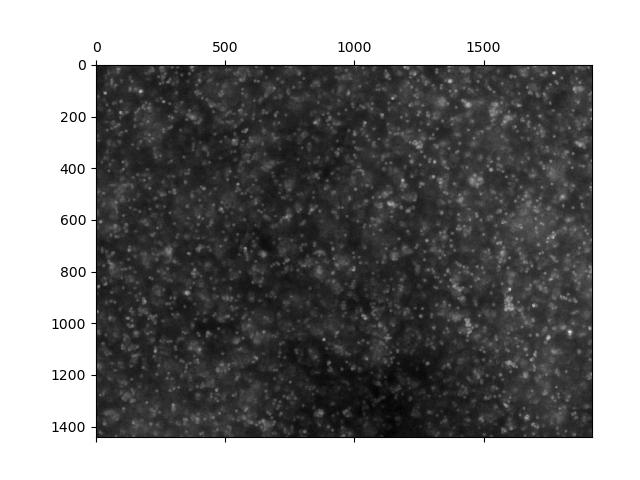

<IPython.core.display.Javascript object>


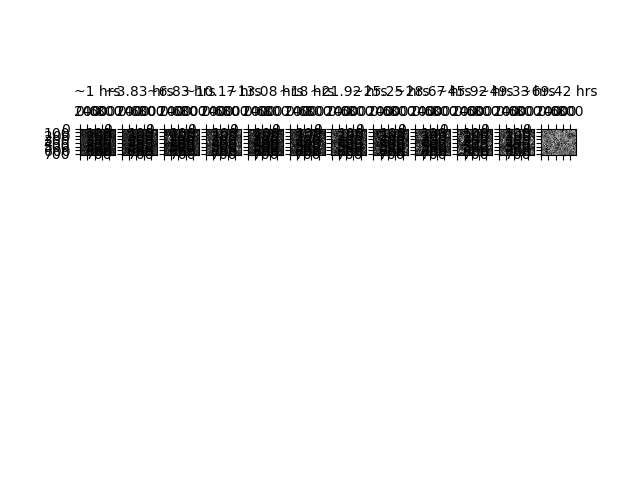

In [21]:
%matplotlib notebook



test_image = tiff_file.imread(files[0],key=[0])
plt.matshow(test_image, cmap = 'gray')

binned_image = downscale_local_mean(test_image, (2,2), cval=1)

fully_processed_image = filtimage(binned_image, filtersize=400)
plt.matshow(fully_processed_image, cmap = 'gray')

In [22]:
im_array = [0.0] * int(len(files))
br_corr_rad_array = [0.0] * int(len(files))
mr_corr_rad_array = [0.0] * int(len(files))
tr_corr_rad_array = [0.0] * int(len(files))

all_xvalues = [0.0] * int(len(files))

<IPython.core.display.Javascript object>


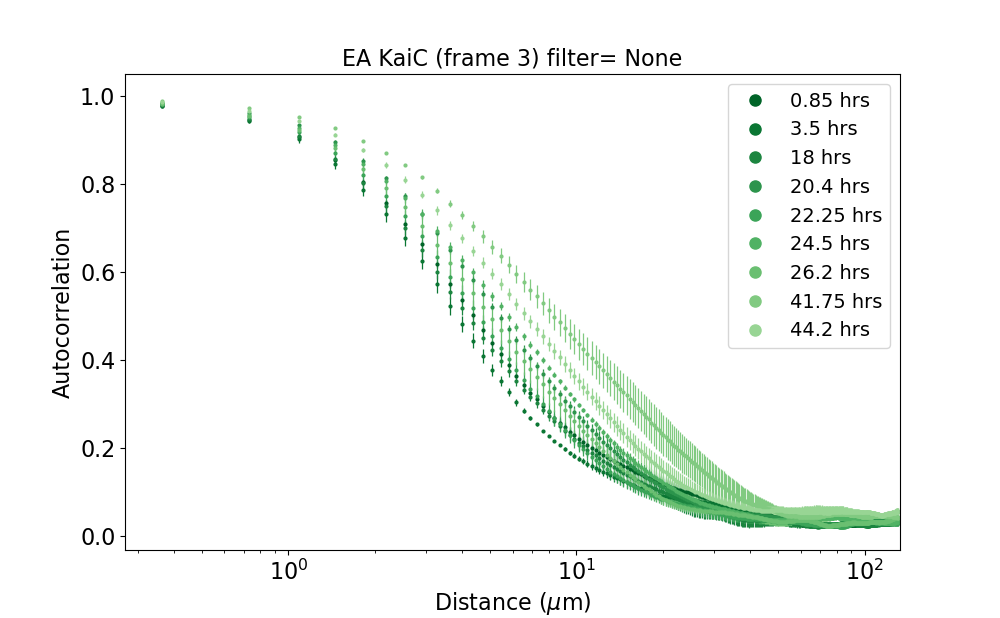

image size: 130.676 x 130.676 um, last x-value= 130.676


<ipython-input-66-d1223b883fc1>:39: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, all_xvalues[-1] +2) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns


In [66]:
key = 2
cmap = matplotlib.cm.get_cmap('Greens')

t_f = False  #use filter? (True = yes, False = no)
size = 700  #set filter size, recommendation = 200

%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 4

cmap_num = (arr_length*2) - 2
mean_corr_rad_array  = [0.0] * int(len(files))
std_error_array = [0.0] * int(len(files))

for i in range(arr_length):    
    frame_num = "frame %i" % int(key +1) 
    full_filename = files[i]
    data_file = str(time_array[i]) + " hrs" 
    br_corr_rad_array[i] = im_corr(tiff_file.imread(files[i],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    mr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+arr_length],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    tr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+(arr_length*2)],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    all_xvalues = np.arange(len(br_corr_rad_array[0]))*pixel_size
    
    all_ims = np.zeros((3,len(br_corr_rad_array[i])))
    all_ims[0] = br_corr_rad_array[i]
    all_ims[1] = mr_corr_rad_array[i]
    all_ims[2] = tr_corr_rad_array[i]
    mean_corr_rad_array[i] = all_ims.mean(axis=0)
    std_error_array[i] = (all_ims.std(axis=0))/np.sqrt(3)
    
    plt.semilogx(all_xvalues, mean_corr_rad_array[i],'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=data_file)
    ax.errorbar(all_xvalues, mean_corr_rad_array[i], std_error_array[i], fmt = 'none', elinewidth=0.9, c=cmap(0.9-(i/cmap_num))) #, capsize=2)

print("image size: %5.3f x %5.3f um, last x-value= %5.3f" %(all_xvalues[-1], all_xvalues[-1], all_xvalues[-1]))
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size) 
ax.legend(loc=0, markerscale=4.,fontsize=font_size-2)
plt.xlim(0, all_xvalues[-1] +2) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
plt.show()

In [67]:
###save figure 
fig.savefig(plot_saveto+"SIA avg w error for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


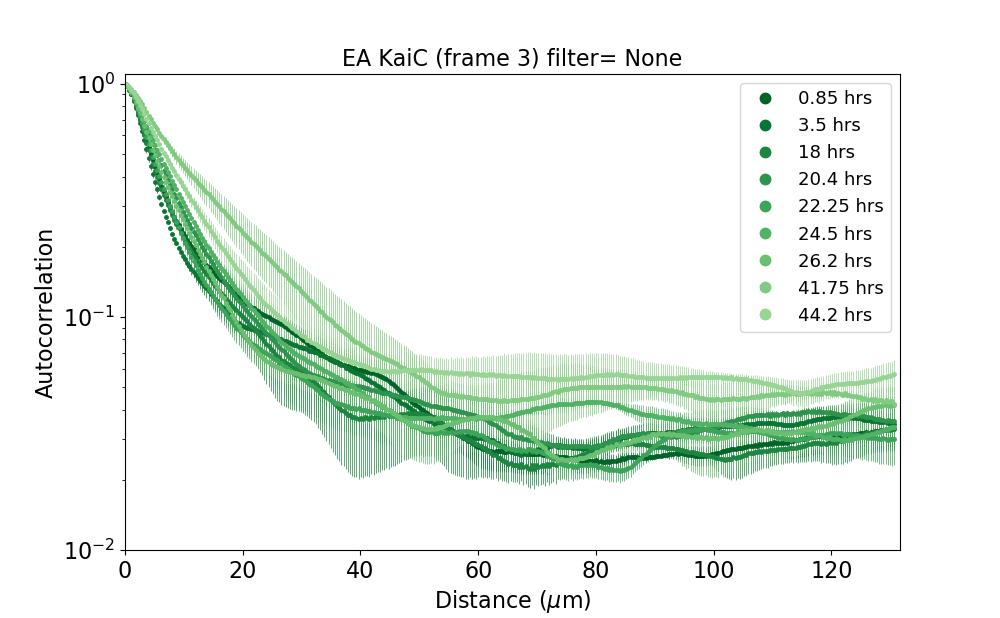

In [68]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" 
    y_array =  mean_corr_rad_array[i]
    plt.semilogy(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=3.,fontsize=font_size-3)
plt.ylim(0.01, 1.1)
plt.xlim(0, all_xvalues[-1] +1) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns

plt.title(title, fontsize=font_size)
###save figure 
fig.savefig(plot_saveto+"SIA semilog-y for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


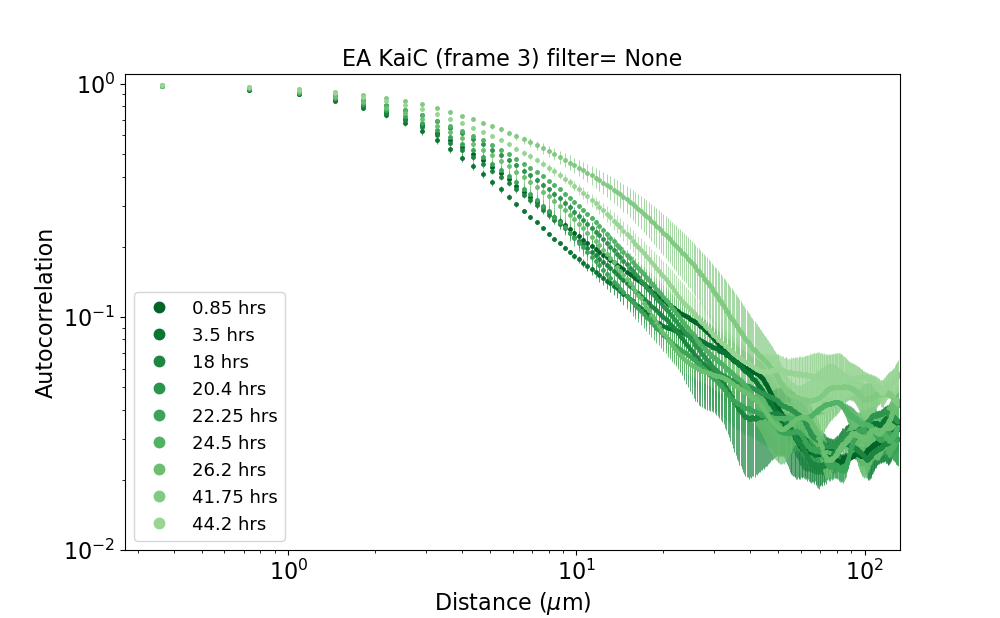

<ipython-input-69-789a4afed38a>:17: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, all_xvalues[-1] +2)


In [69]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" 
    y_array =  mean_corr_rad_array[i]
    plt.loglog(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=3.,fontsize=(font_size-3))
plt.ylim(0.01, 1.1)
plt.xlim(0, all_xvalues[-1] +2)

plt.title(title, fontsize=font_size)
###save figure 
fig.savefig(plot_saveto+"SIA loglog for "+title+".jpg", dpi=dpi_num)

<IPython.core.display.Javascript object>


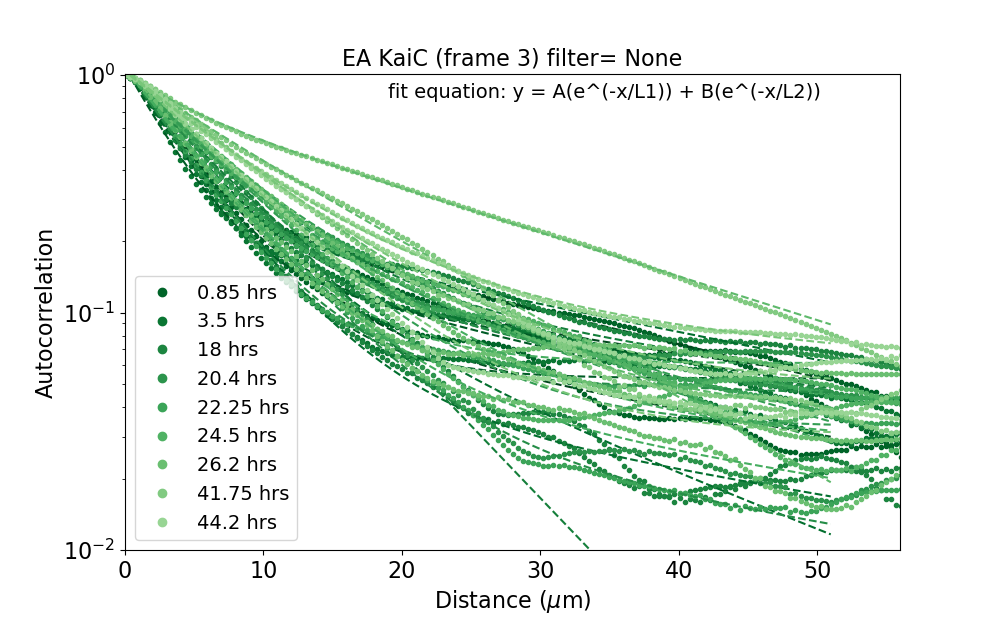

first x-value= 0.364, start fits from 0.364; fit until xlim = 50.960
Fits:
0.85 hrs-- br fit: A=0.924, B=0.145, l1=5.001, l2=52.152
0.85 hrs-- mr fit: A=0.979, B=0.102, l1=4.964, l2=41.730
0.85 hrs-- tr fit: A=0.809, B=0.266, l1=3.808, l2=31.090
------> WTF? br_A + br_B = 1.0688788042111443
3.5 hrs-- br fit: A=1.045, B=0.053, l1=4.737, l2=89683580.665
3.5 hrs-- mr fit: A=0.924, B=0.157, l1=3.657, l2=43.550
3.5 hrs-- tr fit: A=0.922, B=0.179, l1=3.889, l2=32.744
     poor fit at (br) 3.5 hrs
        (br) 3.5 hrs-- xlim= 50.232, fit: A=1.045, B=0.053, l1=4.731, l2=121155621.837
        (br) 3.5 hrs-- xlim= 49.504, fit: A=1.045, B=0.053, l1=4.725, l2=317102029.265
        (br) 3.5 hrs-- xlim= 48.775999999999996, fit: A=1.045, B=0.054, l1=4.720, l2=908535579.178
        (br) 3.5 hrs-- xlim= 48.048, fit: A=1.045, B=0.054, l1=4.716, l2=482841630.254
        (br) 3.5 hrs-- xlim= 47.32, fit: A=1.045, B=0.054, l1=4.711, l2=267289019.656
        (br) 3.5 hrs-- xlim= 46.592, fit: A=1.045, B=0.055

        (tr) 26.2 hrs-- xlim= 46.592, fit: A=1.019, B=0.032, l1=8.093, l2=33497917.733
        (tr) 26.2 hrs-- xlim= 45.864, fit: A=1.019, B=0.032, l1=8.089, l2=47276524.261
        (tr) 26.2 hrs-- xlim= 45.135999999999996, fit: A=1.019, B=0.032, l1=8.086, l2=79481633.972
        (tr) 26.2 hrs-- xlim= 44.408, fit: A=1.019, B=0.032, l1=8.084, l2=28523226.698
   poor fit at (tr) 26.2 hrs --> try single exponential fit
           (tr) 26.2 hrs-- xlim= 50.96, fit: As=1.021, ls=9.170
       yay!! good fit at (tr) 26.2 hrs
       (tr) 26.2 hrs-- xlim= 50.96, fit: As=1.021, ls=9.170
------> WTF? br_A + br_B = 1.0109215646056382
41.75 hrs-- br fit: A=0.146, B=0.893, l1=4.329, l2=13.288
41.75 hrs-- mr fit: A=1.028, B=0.036, l1=9.163, l2=123425435.959
41.75 hrs-- tr fit: A=0.258, B=0.777, l1=4.024, l2=23.534
     poor fit at (mr) 41.75 hrs
        (mr) 41.75 hrs-- xlim= 50.232, fit: A=1.028, B=0.036, l1=9.163, l2=103100377.740
        (mr) 41.75 hrs-- xlim= 49.504, fit: A=1.028, B=0.036, l1=9.16

Text(0.5, 1.0, 'EA KaiC (frame 3) filter= None')

In [70]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

results_dict = {}
results_dict["time array"] = time_array
br_longlengths = [0.0] * arr_length
mr_longlengths = [0.0] * arr_length
tr_longlengths = [0.0] * arr_length

br_shortlengths = [0.0] * arr_length
mr_shortlengths = [0.0] * arr_length
tr_shortlengths = [0.0] * arr_length

fit_lim = -220 #set to -1 to fit over whole range of SIA, adjust as needed (maybe avoid fitting noisy data at edge of range)
retry_num = 10
x_fit_lim = all_xvalues[fit_lim]
print("first x-value= %5.3f, start fits from %5.3f; fit until xlim = %5.3f" %(all_xvalues[1], all_xvalues[1], x_fit_lim))
print("Fits:")

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    #y_array =  mean_corr_rad_array[i]
    br_y_array = br_corr_rad_array[i]
    mr_y_array = mr_corr_rad_array[i]
    tr_y_array = tr_corr_rad_array[i]
    plt.semilogy(all_xvalues,br_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    plt.semilogy(all_xvalues,mr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    plt.semilogy(all_xvalues,tr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    
    ###this section does an 18 degree polynomial fit of the SIA data (corr_rad_array) for each frame
    x_fit_values = np.linspace(all_xvalues[1], all_xvalues[fit_lim], 1000) #all_xvalues #np.linspace(0.19, 50, 1000)
    
    br_popt, br_pcov = curve_fit(double_exponential, all_xvalues[0:fit_lim], br_y_array[0:fit_lim], p0 = [0.5,0.5,5.0,20.0])
    mr_popt, mr_pcov = curve_fit(double_exponential, all_xvalues[0:fit_lim], mr_y_array[0:fit_lim], p0 = [0.5,0.5,5.0,20.0])
    tr_popt, tr_pcov = curve_fit(double_exponential, all_xvalues[0:fit_lim], tr_y_array[0:fit_lim], p0 = [0.5,0.5,5.0,20.0])
    print(time+"-- "+'br fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(br_popt))
    print(time+"-- "+'mr fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(mr_popt))
    print(time+"-- "+'tr fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(tr_popt))
    br_A, br_B, br_l1, br_l2 = tuple(br_popt)
    mr_A, mr_B, mr_l1, mr_l2 = tuple(mr_popt)
    tr_A, tr_B, tr_l1, tr_l2 = tuple(tr_popt)
    
    br_A, br_B, br_l1, br_l2 = check_fits(br_A, br_B, br_l1, br_l2, br_y_array, retry_num)
    mr_A, mr_B, mr_l1, mr_l2 = check_fits(mr_A, mr_B, mr_l1, mr_l2, mr_y_array, retry_num)
    tr_A, tr_B, tr_l1, tr_l2 = check_fits(tr_A, tr_B, tr_l1, tr_l2, tr_y_array, retry_num)
    
    br_fit_values = double_exponential(x_fit_values, *br_popt)
    mr_fit_values = double_exponential(x_fit_values, *mr_popt)
    tr_fit_values = double_exponential(x_fit_values, *tr_popt)
    plt.semilogy(x_fit_values, br_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogy(x_fit_values, mr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogy(x_fit_values, tr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    
    ###saving all data & results to results dictionary 
    results_dict[time] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    results_dict[time]["x vals"] = all_xvalues
    results_dict[time]["br y vals"] = br_y_array
    results_dict[time]["mr y vals"] = mr_y_array
    results_dict[time]["tr y vals"] = tr_y_array
    
    results_dict[time]["avg y vals"] = mean_corr_rad_array[i]
    results_dict[time]["avg y error"] = std_error_array[i]
    
    results_dict[time]["x fit vals"] = x_fit_values
    results_dict[time]["br fit vals"] = br_fit_values
    results_dict[time]["mr fit vals"] = mr_fit_values
    results_dict[time]["tr fit vals"] = tr_fit_values
    
    results_dict[time]["br fit params"] = [br_A, br_B, br_l1, br_l2]
    results_dict[time]["mr fit params"] = [mr_A, mr_B, mr_l1, mr_l2]
    results_dict[time]["tr fit params"] = [tr_A, tr_B, tr_l1, tr_l2]
    
    check_A_B_sum(br_A, br_B, mr_A, mr_B, tr_A, tr_B)
    
    if (br_l1 > br_l2) and (br_l1 != 0) and (br_l2 != 0): ##make sure small length params and large length params are stored properly 
        br_longlengths[i] = (br_A, br_l1)
        br_shortlengths[i] = (br_B, br_l2)
    else:
        br_longlengths[i] = (br_B, br_l2)
        br_shortlengths[i] = (br_A, br_l1)
    if (mr_l1 > mr_l2) and (mr_l1 != 0) and (mr_l2 != 0):
        mr_longlengths[i] = (mr_A, mr_l1)
        mr_shortlengths[i] = (mr_B, mr_l2)
    else:
        mr_longlengths[i] = (mr_B, mr_l2)
        mr_shortlengths[i] = (mr_A, mr_l1)
    if (tr_l1 > tr_l2) and (tr_l1 != 0) and (tr_l2 != 0):
        tr_longlengths[i] = (tr_A, tr_l1)
        tr_shortlengths[i] = (tr_B, tr_l2)
    else:
        tr_longlengths[i] = (tr_B, tr_l2)
        tr_shortlengths[i] = (tr_A, tr_l1)
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=2.,fontsize=font_size-2)
plt.ylim(0.01, 1.01)
plt.xlim(0, all_xvalues[fit_lim]+5) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
ax.text(19,0.8, "fit equation: y = A(e^(-x/L1)) + B(e^(-x/L2))", fontsize=font_size-2)

plt.title(title, fontsize=font_size)

In [71]:
###save figure
fig.savefig(plot_saveto+"SIA fits for "+title+".jpg", dpi=dpi_num)
###save dictionary results 
file_to_write = open(plot_saveto+ "SIA results for "+title+".p", "wb")
pickle.dump(results_dict, file_to_write)

In [72]:
###find average values and std. error for L1 (short lengths) and L2 (long lengths)
all_L1 = np.zeros((3,len(br_longlengths)))
avg_L1 = np.empty(len(br_longlengths))
stderror_L1 = np.empty(len(br_longlengths))

all_L2 = np.zeros((3,len(br_longlengths)))
avg_L2 = np.empty(len(br_longlengths))
stderror_L2 = np.empty(len(br_longlengths))

avg_and_std_error(1,br_longlengths, mr_longlengths, tr_longlengths, avg_L2, stderror_L2)

for i in range(len(br_shortlengths)):
    all_L1[0] = br_shortlengths[i][1]
    all_L1[1] = mr_shortlengths[i][1]
    all_L1[2] = tr_shortlengths[i][1]
    avg_L1[i] = all_L1.mean(axis=0)[0]
    stderror_L1[i] = (all_L1.std(axis=0)[0])/np.sqrt(3)
    print("br_l2= %5.3f, br_l1= %5.3f,   mr_l2= %5.3f, mr_1= %5.3f,   tr_l2= %5.3f, tr_l1 %5.3f," %(br_longlengths[i][1], 
                                                                                                    br_shortlengths[i][1],
                                                                                                    mr_longlengths[i][1], 
                                                                                                    mr_shortlengths[i][1],
                                                                                                    tr_longlengths[i][1], 
                                                                                                    tr_shortlengths[i][1]))

br_l2= 52.152, br_l1= 5.001,   mr_l2= 41.730, mr_1= 4.964,   tr_l2= 31.090, tr_l1 3.808,
br_l2= 0.000, br_l1= 5.835,   mr_l2= 43.550, mr_1= 3.657,   tr_l2= 32.744, tr_l1 3.889,
br_l2= 37.086, br_l1= 3.703,   mr_l2= 18.799, mr_1= 5.246,   tr_l2= 43.791, tr_l1 5.100,
br_l2= 0.000, br_l1= 7.390,   mr_l2= 56.407, mr_1= 5.784,   tr_l2= 52.611, tr_l1 6.416,
br_l2= 50.453, br_l1= 5.509,   mr_l2= 0.000, mr_1= 6.084,   tr_l2= 0.000, tr_l1 6.558,
br_l2= 26.643, br_l1= 6.256,   mr_l2= 23.411, mr_1= 5.727,   tr_l2= 0.000, tr_l1 8.220,
br_l2= 0.000, br_l1= 6.937,   mr_l2= 46.262, mr_1= 5.779,   tr_l2= 0.000, tr_l1 9.170,
br_l2= 13.288, br_l1= 4.329,   mr_l2= 0.000, mr_1= 10.489,   tr_l2= 23.534, tr_l1 4.024,
br_l2= 0.000, br_l1= 8.509,   mr_l2= 115.659, mr_1= 8.837,   tr_l2= 92.070, tr_l1 8.413,


<IPython.core.display.Javascript object>


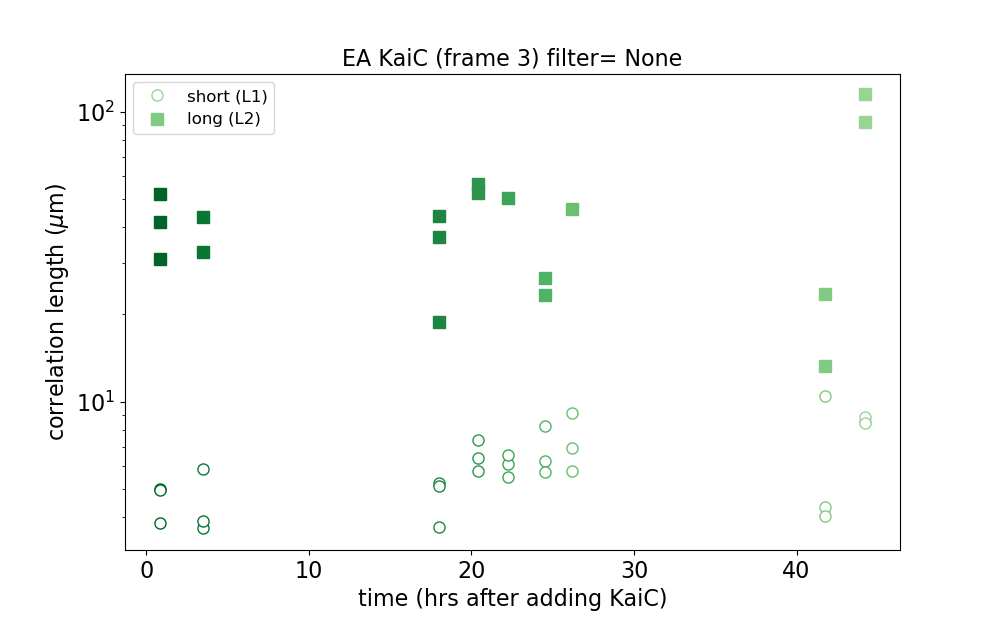

<ipython-input-73-a820070a47dd>:26: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,135)


In [73]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    br_short_plot, = ax.semilogy(time_array[i], br_shortlengths[i][1],'o', markerfacecolor='white',ms=markerSize, 
                                 c=cmap(0.9-(i/cmap_num)), label= "short (L1)")
    mr_short_plot, = ax.semilogy(time_array[i], mr_shortlengths[i][1],'o', markerfacecolor='white',ms=markerSize, 
                                 c=cmap(0.9-(i/cmap_num)), label= "short (L1) -mr")
    tr_short_plot, = ax.semilogy(time_array[i], tr_shortlengths[i][1],'o', markerfacecolor='white',ms=markerSize, 
                                 c=cmap(0.9-(i/cmap_num)), label= "short (L1) -tr")
    if br_longlengths[i][1] != 0:
        br_long_plot, = ax.semilogy(time_array[i], br_longlengths[i][1], 's', ms=markerSize, c=cmap(0.9-(i/cmap_num)), 
                                    label= "long (L2)")
        ax.plot(time_array[i], br_longlengths[i][1], '--', ms=markerSize, c=cmap(0.9-(i/cmap_num)))
    if mr_longlengths[i][1] != 0:
        mr_long_plot, = ax.semilogy(time_array[i], mr_longlengths[i][1], 's', ms=markerSize, c=cmap(0.9-(i/cmap_num)), 
                                    label= "long (L2) -mr")
    if tr_longlengths[i][1] != 0:
        tr_long_plot, = ax.semilogy(time_array[i], tr_longlengths[i][1], 's', ms=markerSize, c=cmap(0.9-(i/cmap_num)), 
                                    label= "long (L2) -tr")

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(0,135)

plt.title(title, fontsize=font_size)
ax.legend(handles =[br_short_plot, br_long_plot], loc ='upper left', markerscale=1.,fontsize=font_size-4)
plt.show()

#fig.savefig(plot_saveto+"L1,L2 correlation lengths for "+title+".jpg", dpi=dpi_num)

In [74]:
br_normalized_short_coeffs = np.empty(len(br_longlengths))
br_normalized_long_coeffs = np.empty(len(br_longlengths))
mr_normalized_short_coeffs = np.empty(len(br_longlengths))
mr_normalized_long_coeffs = np.empty(len(br_longlengths))
tr_normalized_short_coeffs = np.empty(len(br_longlengths))
tr_normalized_long_coeffs = np.empty(len(br_longlengths))

for i in range(len(br_longlengths)):
    br_normalized_short_coeffs[i] = (br_shortlengths[i][0])/(br_shortlengths[i][0] + br_longlengths[i][0])
    mr_normalized_short_coeffs[i] = (mr_shortlengths[i][0])/(mr_shortlengths[i][0] + mr_longlengths[i][0])
    tr_normalized_short_coeffs[i] = (tr_shortlengths[i][0])/(tr_shortlengths[i][0] + tr_longlengths[i][0])
    
    br_normalized_long_coeffs[i] = (br_longlengths[i][0])/(br_shortlengths[i][0] + br_longlengths[i][0])
    mr_normalized_long_coeffs[i] = (mr_longlengths[i][0])/(mr_shortlengths[i][0] + mr_longlengths[i][0])
    tr_normalized_long_coeffs[i] = (tr_longlengths[i][0])/(tr_shortlengths[i][0] + tr_longlengths[i][0])

print(br_normalized_short_coeffs)
print(br_normalized_long_coeffs)

[0.86462853 1.         0.77594736 1.         0.88041783 0.78103304
 1.         0.14077555 1.        ]
[0.13537147 0.         0.22405264 0.         0.11958217 0.21896696
 0.         0.85922445 0.        ]


<IPython.core.display.Javascript object>


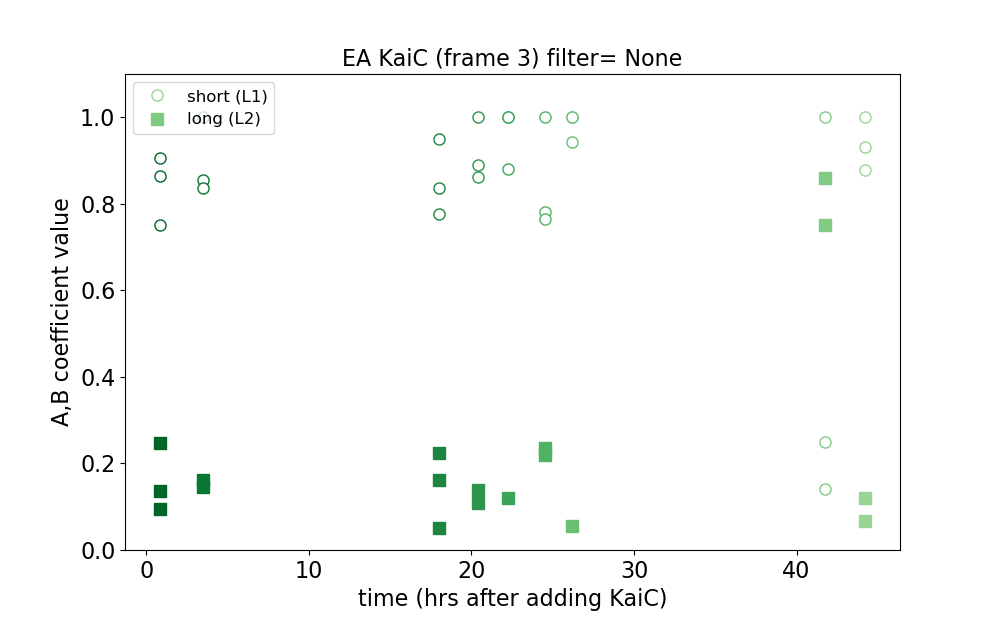

In [76]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    br_short_plot, = ax.plot(time_array[i], br_normalized_short_coeffs[i],'o', markerfacecolor='white',ms=markerSize, 
                                 c=cmap(0.9-(i/cmap_num)), label= "short (L1)")
    mr_short_plot, = ax.plot(time_array[i], mr_normalized_short_coeffs[i],'o', markerfacecolor='white',ms=markerSize, 
                                 c=cmap(0.9-(i/cmap_num)), label= "short (L1) -mr")
    tr_short_plot, = ax.plot(time_array[i], tr_normalized_short_coeffs[i],'o', markerfacecolor='white',ms=markerSize, 
                                 c=cmap(0.9-(i/cmap_num)), label= "short (L1) -tr")
    if br_normalized_long_coeffs[i] != 0:
        br_long_plot, = ax.plot(time_array[i], br_normalized_long_coeffs[i], 's', ms=markerSize, c=cmap(0.9-(i/cmap_num)), 
                                    label= "long (L2)")
    if mr_normalized_long_coeffs[i] != 0:
        mr_long_plot, = ax.plot(time_array[i], mr_normalized_long_coeffs[i], 's', ms=markerSize, c=cmap(0.9-(i/cmap_num)), 
                                    label= "long (L2) -mr")
    if tr_normalized_long_coeffs[i] != 0:
        tr_long_plot, = ax.plot(time_array[i], tr_normalized_long_coeffs[i], 's', ms=markerSize, c=cmap(0.9-(i/cmap_num)), 
                                    label= "long (L2) -tr")

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("A,B coefficient value",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(0,1.1)
plt.title(title, fontsize=font_size)
ax.legend(handles =[br_short_plot, br_long_plot], loc ='upper left', markerscale=1.,fontsize=font_size-4)
plt.show()

fig.savefig(plot_saveto+"A,B coefficients for "+title+".jpg", dpi=dpi_num)

In [ ]:
###save all results to 3 seperate CSV files --> use for plotting in origin later on 
csv_data_file = "results- SIA fit parameters for "+title+".csv"
header = []
_ = np.zeros(len(time_array))
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['time (hrs)', 'br A','mr A','tr A','avg A','A std. error',' ','br B','mr B','tr B','avg B','B std. error',
                     ' ','br L1','mr L1','tr L1','avg L1','L1 std. error',' ','br L2','mr L2','tr L2','avg L2','L2 std. error'])
    for i in range(len(time_array)):
        writer.writerow([time_array[i],
            br_shortlengths[i][0],mr_shortlengths[i][0],tr_shortlengths[i][0],avg_short_coeffs[i],stderror_short_coeffs[i],_[i],
            br_longlengths[i][0],mr_longlengths[i][0],tr_longlengths[i][0],avg_long_coeffs[i],stderror_long_coeffs[i],_[i],
            br_shortlengths[i][1],mr_shortlengths[i][1],tr_shortlengths[i][1],avg_L1[i],stderror_L1[i],_[i],
            br_longlengths[i][1],mr_longlengths[i][1],tr_longlengths[i][1],avg_L2[i],stderror_L2[i]])
    writer.writerow([''])
f.close()

csv_data_file = "results- SIA raw data for "+title+".csv"   
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x vals','br y vals','mr y vals','tr y vals', 'avg y vals','avg y error'])
        for i in range(len(results_dict[time]['x vals'])):
            writer.writerow([results_dict[time]['x vals'][i], results_dict[time]['br y vals'][i],
                            results_dict[time]['mr y vals'][i], results_dict[time]['tr y vals'][i],
                            results_dict[time]['avg y vals'][i], results_dict[time]['avg y error'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

csv_data_file = "results- SIA fits data for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x fit vals','br fit vals','mr fit vals','tr fit vals'])
        for i in range(len(results_dict[time]['x fit vals'])):
            writer.writerow([results_dict[time]['x fit vals'][i], results_dict[time]['br fit vals'][i],
                            results_dict[time]['mr fit vals'][i], results_dict[time]['tr fit vals'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

In [ ]:
cmap = matplotlib.cm.get_cmap('Blues')
key = 1

t_f = False  #use filter? (True = yes, False = no)
size = 700  #set filter size, recommendation = 200

%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 4

cmap_num = (arr_length*2) - 2
mean_corr_rad_array  = [0.0] * int(len(files))
std_error_array = [0.0] * int(len(files))

for i in range(arr_length):    
    frame_num = "frame %i" % int(key +1) 
    full_filename = files[i]
    data_file = str(time_array[i]) + " hrs" 
    br_corr_rad_array[i] = im_corr(tiff_file.imread(files[i],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    mr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+arr_length],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    tr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+(arr_length*2)],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    all_xvalues = np.arange(len(br_corr_rad_array[0]))*pixel_size
    
    all_ims = np.zeros((3,len(br_corr_rad_array[i])))
    all_ims[0] = br_corr_rad_array[i]
    all_ims[1] = mr_corr_rad_array[i]
    all_ims[2] = tr_corr_rad_array[i]
    mean_corr_rad_array[i] = all_ims.mean(axis=0)
    std_error_array[i] = (all_ims.std(axis=0))/np.sqrt(3)
    
    plt.semilogx(all_xvalues, mean_corr_rad_array[i],'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=data_file)
    ax.errorbar(all_xvalues, mean_corr_rad_array[i], std_error_array[i], fmt = 'none', elinewidth=0.9, c=cmap(0.9-(i/cmap_num))) #, capsize=2)

print("image size: %5.3f x %5.3f um, last x-value= %5.3f" %(all_xvalues[-1], all_xvalues[-1], all_xvalues[-1]))
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size) 
ax.legend(loc=0, markerscale=4.,fontsize=font_size-2)
plt.xlim(0, all_xvalues[-1] +2) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
plt.show()

In [ ]:
###save figure 
fig.savefig(plot_saveto+"SIA avg w error for "+title+".jpg", dpi=dpi_num)

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" 
    y_array =  mean_corr_rad_array[i]
    plt.semilogy(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=3.,fontsize=font_size-3)
plt.ylim(0.01, 1.1)
plt.xlim(0, all_xvalues[-1] +1) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns

plt.title(title, fontsize=font_size)
###save figure 
fig.savefig(plot_saveto+"SIA semilog-y for "+title+".jpg", dpi=dpi_num)

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" 
    y_array =  mean_corr_rad_array[i]
    plt.loglog(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=3.,fontsize=(font_size-3))
plt.ylim(0.01, 1.1)
plt.xlim(0, all_xvalues[-1] +2)

plt.title(title, fontsize=font_size)
###save figure 
fig.savefig(plot_saveto+"SIA loglog for "+title+".jpg", dpi=dpi_num)

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

results_dict = {}
results_dict["time array"] = time_array
br_longlengths = [0.0] * arr_length
mr_longlengths = [0.0] * arr_length
tr_longlengths = [0.0] * arr_length

br_shortlengths = [0.0] * arr_length
mr_shortlengths = [0.0] * arr_length
tr_shortlengths = [0.0] * arr_length

fit_lim = -250 #set to -1 to fit over whole range of SIA, adjust as needed (maybe avoid fitting noisy data at edge of range)
retry_num = 20
x_fit_lim = all_xvalues[fit_lim]
print("first x-value= %5.3f, start fits from %5.3f; fit until xlim = %5.3f" %(all_xvalues[1], all_xvalues[1], x_fit_lim))
print("Fits:")

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    #y_array =  mean_corr_rad_array[i]
    br_y_array = br_corr_rad_array[i]
    mr_y_array = mr_corr_rad_array[i]
    tr_y_array = tr_corr_rad_array[i]
    plt.semilogy(all_xvalues,br_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    plt.semilogy(all_xvalues,mr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    plt.semilogy(all_xvalues,tr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    
    ###this section does an 18 degree polynomial fit of the SIA data (corr_rad_array) for each frame
    x_fit_values = np.linspace(all_xvalues[1], all_xvalues[fit_lim], 1000) #all_xvalues #np.linspace(0.19, 50, 1000)
    
    br_popt, br_pcov = curve_fit(double_exponential, all_xvalues[0:fit_lim], br_y_array[0:fit_lim], p0 = [0.5,0.5,5.0,20.0])
    mr_popt, mr_pcov = curve_fit(double_exponential, all_xvalues[0:fit_lim], mr_y_array[0:fit_lim], p0 = [0.5,0.5,5.0,20.0])
    tr_popt, tr_pcov = curve_fit(double_exponential, all_xvalues[0:fit_lim], tr_y_array[0:fit_lim], p0 = [0.5,0.5,5.0,20.0])
    print(time+"-- "+'br fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(br_popt))
    print(time+"-- "+'mr fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(mr_popt))
    print(time+"-- "+'tr fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(tr_popt))
    br_A, br_B, br_l1, br_l2 = tuple(br_popt)
    mr_A, mr_B, mr_l1, mr_l2 = tuple(mr_popt)
    tr_A, tr_B, tr_l1, tr_l2 = tuple(tr_popt)
    
    br_popt = check_fits(br_A, br_B, br_l1, br_l2, br_y_array, retry_num)
    mr_popt = check_fits(mr_A, mr_B, mr_l1, mr_l2, mr_y_array, retry_num)
    tr_popt = check_fits(tr_A, tr_B, tr_l1, tr_l2, tr_y_array, retry_num)
    br_A, br_B, br_l1, br_l2 = tuple(br_popt)
    mr_A, mr_B, mr_l1, mr_l2 = tuple(mr_popt)
    tr_A, tr_B, tr_l1, tr_l2 = tuple(tr_popt)

    #br_popt = if_single_exp(br_popt)
    #mr_popt = if_single_exp(mr_popt)
    #tr_popt = if_single_exp(tr_popt)
    
    br_fit_values = if_single_exp(br_popt)
    mr_fit_values = if_single_exp(mr_popt)
    tr_fit_values = if_single_exp(tr_popt)
    plt.semilogy(x_fit_values, br_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogy(x_fit_values, mr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogy(x_fit_values, tr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    
    ###saving all data & results to results dictionary 
    results_dict[time] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    results_dict[time]["x vals"] = all_xvalues
    results_dict[time]["br y vals"] = br_y_array
    results_dict[time]["mr y vals"] = mr_y_array
    results_dict[time]["tr y vals"] = tr_y_array
    
    results_dict[time]["avg y vals"] = mean_corr_rad_array[i]
    results_dict[time]["avg y error"] = std_error_array[i]
    
    results_dict[time]["x fit vals"] = x_fit_values
    results_dict[time]["br fit vals"] = br_fit_values
    results_dict[time]["mr fit vals"] = mr_fit_values
    results_dict[time]["tr fit vals"] = tr_fit_values
    
    results_dict[time]["br fit params"] = [br_A, br_B, br_l1, br_l2]
    results_dict[time]["mr fit params"] = [mr_A, mr_B, mr_l1, mr_l2]
    results_dict[time]["tr fit params"] = [tr_A, tr_B, tr_l1, tr_l2]
    
    if (br_l1 > br_l2): ##make sure small length params and large length params are stored properly 
        br_longlengths[i] = (br_A, br_l1)
        br_shortlengths[i] = (br_B, br_l2)
    else:
        br_longlengths[i] = (br_B, br_l2)
        br_shortlengths[i] = (br_A, br_l1)
    if (mr_l1 > mr_l2):
        mr_longlengths[i] = (mr_A, mr_l1)
        mr_shortlengths[i] = (mr_B, mr_l2)
    else:
        mr_longlengths[i] = (mr_B, mr_l2)
        mr_shortlengths[i] = (mr_A, mr_l1)
    if (tr_l1 > tr_l2):
        tr_longlengths[i] = (tr_A, tr_l1)
        tr_shortlengths[i] = (tr_B, tr_l2)
    else:
        tr_longlengths[i] = (tr_B, tr_l2)
        tr_shortlengths[i] = (tr_A, tr_l1)
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=2.,fontsize=font_size-2)
plt.ylim(0.01, 1.01)
plt.xlim(0, all_xvalues[fit_lim]+5) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
ax.text(19,0.8, "fit equation: y = A(e^(-x/L1)) + B(e^(-x/L2))", fontsize=font_size-2)

plt.title(title, fontsize=font_size)

In [ ]:
###save figure
fig.savefig(plot_saveto+"SIA fits for "+title+".jpg", dpi=dpi_num)
###save dictionary results 
file_to_write = open(plot_saveto+ "SIA results for "+title+".p", "wb")
pickle.dump(results_dict, file_to_write)

In [ ]:
###find average values and std. error for L1 (short lengths) and L2 (long lengths)
all_L1 = np.zeros((3,len(br_longlengths)))
avg_L1 = np.empty(len(br_longlengths))
stderror_L1 = np.empty(len(br_longlengths))

all_L2 = np.zeros((3,len(br_longlengths)))
avg_L2 = np.empty(len(br_longlengths))
stderror_L2 = np.empty(len(br_longlengths))
empty = np.empty(len(br_longlengths))

def skip_when_params_equal_zero(lengths_array, all_array):
    if lengths_array == 0:
        all_array = empty[i]
    else:
        all_array = lengths_array

for i in range(len(br_longlengths)):
    
    all_L1[0] = br_shortlengths[i][1]
    all_L1[1] = mr_shortlengths[i][1]
    all_L1[2] = tr_shortlengths[i][1]
    avg_L1[i] = all_L1.mean(axis=0)[0]
    stderror_L1[i] = (all_L1.std(axis=0)[0])/np.sqrt(3)
    
    all_L2[0] = br_longlengths[i][1]
    all_L2[1] = mr_longlengths[i][1]
    all_L2[2] = tr_longlengths[i][1]
    avg_L2[i] = all_L2.mean(axis=0)[0]
    stderror_L2[i] = (all_L2.std(axis=0)[0])/np.sqrt(3)
    print("br_l2= %5.3f, br_l1= %5.3f,   mr_l2= %5.3f, mr_l1= %5.3f,   tr_l2= %5.3f, tr_l1 %5.3f," %(br_longlengths[i][1], 
                                                                                                    br_shortlengths[i][1],
                                                                                                    mr_longlengths[i][1], 
                                                                                                    mr_shortlengths[i][1],
                                                                                                    tr_longlengths[i][1], 
                                                                                                    tr_shortlengths[i][1]))
print(all_L2)

In [ ]:
###find average values and std. error for L1 (short lengths) and L2 (long lengths)
all_L1 = np.zeros((3,len(br_longlengths)))
avg_L1 = np.empty(len(br_longlengths))
stderror_L1 = np.empty(len(br_longlengths))

all_L2 = np.zeros((3,len(br_longlengths)))
avg_L2 = np.empty(len(br_longlengths))
stderror_L2 = np.empty(len(br_longlengths))
empty = np.empty(len(br_longlengths))

def skip_when_params_equal_zero(all_array, lengths_array):
    if lengths_array != 0:
        all_array = lengths_array
        print(all_array)
    else:
        all_array = empty[i]

for i in range(len(br_longlengths)):
    skip_when_params_equal_zero(all_L1[0], br_shortlengths[i][1])
    skip_when_params_equal_zero(all_L1[1], mr_shortlengths[i][1])
    skip_when_params_equal_zero(all_L1[2], tr_shortlengths[i][1])
    avg_L1[i] = all_L1.mean(axis=0)[0]
    stderror_L1[i] = (all_L1.std(axis=0)[0])/np.sqrt(3)
    
    all_L2[0] = br_longlengths[i][1]
    all_L2[1] = mr_longlengths[i][1]
    all_L2[2] = tr_longlengths[i][1]
    avg_L2[i] = all_L2.mean(axis=0)[0]
    stderror_L2[i] = (all_L2.std(axis=0)[0])/np.sqrt(3)
    print("br_l2= %5.3f, br_l1= %5.3f,   mr_l2= %5.3f, mr_l1= %5.3f,   tr_l2= %5.3f, tr_l1 %5.3f," %(br_longlengths[i][1], 
                                                                                                    br_shortlengths[i][1],
                                                                                                    mr_longlengths[i][1], 
                                                                                                    mr_shortlengths[i][1],
                                                                                                    tr_longlengths[i][1], 
                                                                                                    tr_shortlengths[i][1]))
print(all_L2)

In [ ]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    short_plot, = ax.semilogy(time_array[i], avg_L1[i],'o', markerfacecolor='white',ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "short (L1)")
    ax.errorbar(time_array[i], avg_L1[i], stderror_L1[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    long_plot, = ax.semilogy(time_array[i], avg_L2[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "long (L2)")
    ax.errorbar(time_array[i], avg_L2[i], stderror_L2[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(0,100)

plt.title(title, fontsize=font_size)
ax.legend(handles =[short_plot, long_plot], loc ='upper left', markerscale=1.,fontsize=font_size-4)
plt.show()

fig.savefig(plot_saveto+"L1,L2 correlation lengths for "+title+".jpg", dpi=dpi_num)

In [ ]:
all_long_coeffs = np.zeros((3,len(br_longlengths)))
avg_long_coeffs = np.empty(len(br_longlengths))
stderror_long_coeffs = np.empty(len(br_longlengths))

all_short_coeffs = np.zeros((3,len(br_longlengths)))
avg_short_coeffs = np.empty(len(br_longlengths))
stderror_short_coeffs = np.empty(len(br_longlengths))
for i in range(len(br_longlengths)):
    all_short_coeffs[0] = br_shortlengths[i][0]
    all_short_coeffs[1] = mr_shortlengths[i][0]
    all_short_coeffs[2] = tr_shortlengths[i][0]
    avg_short_coeffs[i] = all_short_coeffs.mean(axis=0)[0]
    stderror_short_coeffs[i] = (all_short_coeffs.std(axis=0)[0])/np.sqrt(3)
    
    all_long_coeffs[0] = br_longlengths[i][0]
    all_long_coeffs[1] = mr_longlengths[i][0]
    all_long_coeffs[2] = tr_longlengths[i][0]
    avg_long_coeffs[i] = all_long_coeffs.mean(axis=0)[0]
    stderror_long_coeffs[i] = (all_long_coeffs.std(axis=0)[0])/np.sqrt(3)
    
print(avg_long_coeffs)
print(stderror_long_coeffs)
print(avg_short_coeffs)
print(stderror_short_coeffs)

In [ ]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    short_plot, = ax.plot(time_array[i], avg_short_coeffs[i],'o', markerfacecolor='white',ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "A (L1, short)")
    ax.errorbar(time_array[i], avg_short_coeffs[i], stderror_short_coeffs[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    long_plot, = ax.plot(time_array[i], avg_long_coeffs[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "B (L2, long)")
    ax.errorbar(time_array[i], avg_long_coeffs[i], stderror_long_coeffs[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("A,B coefficient value",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(0,1)
plt.title(title, fontsize=font_size)
ax.legend(handles =[short_plot, long_plot], loc ='upper left', markerscale=1.,fontsize=font_size-4)
plt.show()

fig.savefig(plot_saveto+"A,B coefficients for "+title+".jpg", dpi=dpi_num)

In [ ]:
###save all results to 3 seperate CSV files --> use for plotting in origin later on 
csv_data_file = "results- SIA fit parameters for "+title+".csv"
header = []
_ = np.zeros(len(time_array))
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['time (hrs)', 'br A','mr A','tr A','avg A','A std. error',' ','br B','mr B','tr B','avg B','B std. error',
                     ' ','br L1','mr L1','tr L1','avg L1','L1 std. error',' ','br L2','mr L2','tr L2','avg L2','L2 std. error'])
    for i in range(len(time_array)):
        writer.writerow([time_array[i],
            br_shortlengths[i][0],mr_shortlengths[i][0],tr_shortlengths[i][0],avg_short_coeffs[i],stderror_short_coeffs[i],_[i],
            br_longlengths[i][0],mr_longlengths[i][0],tr_longlengths[i][0],avg_long_coeffs[i],stderror_long_coeffs[i],_[i],
            br_shortlengths[i][1],mr_shortlengths[i][1],tr_shortlengths[i][1],avg_L1[i],stderror_L1[i],_[i],
            br_longlengths[i][1],mr_longlengths[i][1],tr_longlengths[i][1],avg_L2[i],stderror_L2[i]])
    writer.writerow([''])
f.close()

csv_data_file = "results- SIA raw data for "+title+".csv"   
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x vals','br y vals','mr y vals','tr y vals', 'avg y vals','avg y error'])
        for i in range(len(results_dict[time]['x vals'])):
            writer.writerow([results_dict[time]['x vals'][i], results_dict[time]['br y vals'][i],
                            results_dict[time]['mr y vals'][i], results_dict[time]['tr y vals'][i],
                            results_dict[time]['avg y vals'][i], results_dict[time]['avg y error'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

csv_data_file = "results- SIA fits data for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x fit vals','br fit vals','mr fit vals','tr fit vals'])
        for i in range(len(results_dict[time]['x fit vals'])):
            writer.writerow([results_dict[time]['x fit vals'][i], results_dict[time]['br fit vals'][i],
                            results_dict[time]['mr fit vals'][i], results_dict[time]['tr fit vals'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

In [ ]:
key = 2
cmap = matplotlib.cm.get_cmap('Greens')

t_f = False  #use filter? (True = yes, False = no)
size = 700  #set filter size, recommendation = 200

%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 4

cmap_num = (arr_length*2) - 2
mean_corr_rad_array  = [0.0] * int(len(files))
std_error_array = [0.0] * int(len(files))

for i in range(arr_length):    
    frame_num = "frame %i" % int(key +1) 
    full_filename = files[i]
    data_file = str(time_array[i]) + " hrs" 
    br_corr_rad_array[i] = im_corr(tiff_file.imread(files[i],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    mr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+arr_length],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    tr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+(arr_length*2)],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    all_xvalues = np.arange(len(br_corr_rad_array[0]))*pixel_size
    
    all_ims = np.zeros((3,len(br_corr_rad_array[i])))
    all_ims[0] = br_corr_rad_array[i]
    all_ims[1] = mr_corr_rad_array[i]
    all_ims[2] = tr_corr_rad_array[i]
    mean_corr_rad_array[i] = all_ims.mean(axis=0)
    std_error_array[i] = (all_ims.std(axis=0))/np.sqrt(3)
    
    plt.semilogx(all_xvalues, mean_corr_rad_array[i],'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=data_file)
    ax.errorbar(all_xvalues, mean_corr_rad_array[i], std_error_array[i], fmt = 'none', elinewidth=0.9, c=cmap(0.9-(i/cmap_num))) #, capsize=2)

print("image size: %5.3f x %5.3f um, last x-value= %5.3f" %(all_xvalues[-1], all_xvalues[-1], all_xvalues[-1]))
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size) 
ax.legend(loc=0, markerscale=4.,fontsize=font_size-2)
plt.xlim(0, all_xvalues[-1] +2) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
plt.show()

In [ ]:
###save figure 
fig.savefig(plot_saveto+"SIA avg w error for "+title+".jpg", dpi=dpi_num)

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" 
    y_array =  mean_corr_rad_array[i]
    plt.semilogy(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=3.,fontsize=font_size-3)
plt.ylim(0.01, 1.1)
plt.xlim(0, all_xvalues[-1] +1) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns

plt.title(title, fontsize=font_size)
###save figure 
fig.savefig(plot_saveto+"SIA semilog-y for "+title+".jpg", dpi=dpi_num)

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" 
    y_array =  mean_corr_rad_array[i]
    plt.loglog(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=3.,fontsize=(font_size-3))
plt.ylim(0.01, 1.1)
plt.xlim(0, all_xvalues[-1] +2)

plt.title(title, fontsize=font_size)
###save figure 
fig.savefig(plot_saveto+"SIA loglog for "+title+".jpg", dpi=dpi_num)

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

results_dict = {}
results_dict["time array"] = time_array
br_longlengths = [0.0] * arr_length
mr_longlengths = [0.0] * arr_length
tr_longlengths = [0.0] * arr_length

br_shortlengths = [0.0] * arr_length
mr_shortlengths = [0.0] * arr_length
tr_shortlengths = [0.0] * arr_length

fit_lim = -250 #set to -1 to fit over whole range of SIA, adjust as needed (maybe avoid fitting noisy data at edge of range)
x_fit_lim = all_xvalues[fit_lim]
print("first x-value= %5.3f, start fits from %5.3f; fit until xlim = %5.3f" %(all_xvalues[1], all_xvalues[1], x_fit_lim))
print("Fits:")

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    #y_array =  mean_corr_rad_array[i]
    br_y_array = br_corr_rad_array[i]
    mr_y_array = mr_corr_rad_array[i]
    tr_y_array = tr_corr_rad_array[i]
    plt.semilogy(all_xvalues,br_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    plt.semilogy(all_xvalues,mr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    plt.semilogy(all_xvalues,tr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    
    ###this section does an 18 degree polynomial fit of the SIA data (corr_rad_array) for each frame
    x_fit_values = np.linspace(all_xvalues[1], all_xvalues[fit_lim], 1000) #all_xvalues #np.linspace(0.19, 50, 1000)
    
    br_popt, br_pcov = curve_fit(double_exponential, all_xvalues[0:fit_lim], br_y_array[0:fit_lim], p0 = [0.5,0.5,5.0,20.0])
    mr_popt, mr_pcov = curve_fit(double_exponential, all_xvalues[0:fit_lim], mr_y_array[0:fit_lim], p0 = [0.5,0.5,5.0,20.0])
    tr_popt, tr_pcov = curve_fit(double_exponential, all_xvalues[0:fit_lim], tr_y_array[0:fit_lim], p0 = [0.5,0.5,5.0,20.0])
    print(time+"-- "+'br fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(br_popt))
    print(time+"-- "+'mr fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(mr_popt))
    print(time+"-- "+'tr fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(tr_popt))
    br_A, br_B, br_l1, br_l2 = tuple(br_popt)
    mr_A, mr_B, mr_l1, mr_l2 = tuple(mr_popt)
    tr_A, tr_B, tr_l1, tr_l2 = tuple(tr_popt)
    
    br_A, br_B, br_l1, br_l2 = check_fits(br_A, br_B, br_l1, br_l2, br_y_array)
    mr_A, mr_B, mr_l1, mr_l2 = check_fits(mr_A, mr_B, mr_l1, mr_l2, mr_y_array)
    tr_A, tr_B, tr_l1, tr_l2 = check_fits(tr_A, tr_B, tr_l1, tr_l2, tr_y_array)
    
    br_fit_values = double_exponential(x_fit_values, *br_popt)
    mr_fit_values = double_exponential(x_fit_values, *mr_popt)
    tr_fit_values = double_exponential(x_fit_values, *tr_popt)
    plt.semilogy(x_fit_values, br_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogy(x_fit_values, mr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogy(x_fit_values, tr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    
    ###saving all data & results to results dictionary 
    results_dict[time] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    results_dict[time]["x vals"] = all_xvalues
    results_dict[time]["br y vals"] = br_y_array
    results_dict[time]["mr y vals"] = mr_y_array
    results_dict[time]["tr y vals"] = tr_y_array
    
    results_dict[time]["avg y vals"] = mean_corr_rad_array[i]
    results_dict[time]["avg y error"] = std_error_array[i]
    
    results_dict[time]["x fit vals"] = x_fit_values
    results_dict[time]["br fit vals"] = br_fit_values
    results_dict[time]["mr fit vals"] = mr_fit_values
    results_dict[time]["tr fit vals"] = tr_fit_values
    
    results_dict[time]["br fit params"] = [br_A, br_B, br_l1, br_l2]
    results_dict[time]["mr fit params"] = [mr_A, mr_B, mr_l1, mr_l2]
    results_dict[time]["tr fit params"] = [tr_A, tr_B, tr_l1, tr_l2]
    
    if (br_l1 > br_l2): ##make sure small length params and large length params are stored properly 
        br_longlengths[i] = (br_A, br_l1)
        br_shortlengths[i] = (br_B, br_l2)
    else:
        br_longlengths[i] = (br_B, br_l2)
        br_shortlengths[i] = (br_A, br_l1)
    if (mr_l1 > mr_l2):
        mr_longlengths[i] = (mr_A, mr_l1)
        mr_shortlengths[i] = (mr_B, mr_l2)
    else:
        mr_longlengths[i] = (mr_B, mr_l2)
        mr_shortlengths[i] = (mr_A, mr_l1)
    if (tr_l1 > tr_l2):
        tr_longlengths[i] = (tr_A, tr_l1)
        tr_shortlengths[i] = (tr_B, tr_l2)
    else:
        tr_longlengths[i] = (tr_B, tr_l2)
        tr_shortlengths[i] = (tr_A, tr_l1)
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=2.,fontsize=font_size-2)
plt.ylim(0.01, 1.01)
plt.xlim(0, all_xvalues[fit_lim]+5) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
ax.text(19,0.8, "fit equation: y = A(e^(-x/L1)) + B(e^(-x/L2))", fontsize=font_size-2)

plt.title(title, fontsize=font_size)

In [ ]:
###save figure
fig.savefig(plot_saveto+"SIA fits for "+title+".jpg", dpi=dpi_num)
###save dictionary results 
file_to_write = open(plot_saveto+ "SIA results for "+title+".p", "wb")
pickle.dump(results_dict, file_to_write)

In [ ]:
###find average values and std. error for L1 (short lengths) and L2 (long lengths)
all_L1 = np.zeros((3,len(br_longlengths)))
avg_L1 = np.empty(len(br_longlengths))
stderror_L1 = np.empty(len(br_longlengths))

all_L2 = np.zeros((3,len(br_longlengths)))
avg_L2 = np.empty(len(br_longlengths))
stderror_L2 = np.empty(len(br_longlengths))

for i in range(len(br_longlengths)):
    all_L1[0] = br_shortlengths[i][1]
    all_L1[1] = mr_shortlengths[i][1]
    all_L1[2] = tr_shortlengths[i][1]
    avg_L1[i] = all_L1.mean(axis=0)[0]
    stderror_L1[i] = (all_L1.std(axis=0)[0])/np.sqrt(3)
    
    all_L2[0] = br_longlengths[i][1]
    all_L2[1] = mr_longlengths[i][1]
    all_L2[2] = tr_longlengths[i][1]
    avg_L2[i] = all_L2.mean(axis=0)[0]
    stderror_L2[i] = (all_L2.std(axis=0)[0])/np.sqrt(3)
    print("br_l2= %5.3f, br_l1= %5.3f,   mr_l2= %5.3f, mr_1= %5.3f,   tr_l2= %5.3f, tr_l1 %5.3f," %(br_longlengths[i][1], 
                                                                                                    br_shortlengths[i][1],
                                                                                                    mr_longlengths[i][1], 
                                                                                                    mr_shortlengths[i][1],
                                                                                                    tr_longlengths[i][1], 
                                                                                                    tr_shortlengths[i][1]))

In [ ]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    short_plot, = ax.semilogy(time_array[i], avg_L1[i],'o', markerfacecolor='white',ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "short (L1)")
    ax.errorbar(time_array[i], avg_L1[i], stderror_L1[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    long_plot, = ax.semilogy(time_array[i], avg_L2[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "long (L2)")
    ax.errorbar(time_array[i], avg_L2[i], stderror_L2[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(0,100)

plt.title(title, fontsize=font_size)
ax.legend(handles =[short_plot, long_plot], loc ='upper left', markerscale=1.,fontsize=font_size-4)
plt.show()

fig.savefig(plot_saveto+"L1,L2 correlation lengths for "+title+".jpg", dpi=dpi_num)

In [ ]:
all_long_coeffs = np.zeros((3,len(br_longlengths)))
avg_long_coeffs = np.empty(len(br_longlengths))
stderror_long_coeffs = np.empty(len(br_longlengths))

all_short_coeffs = np.zeros((3,len(br_longlengths)))
avg_short_coeffs = np.empty(len(br_longlengths))
stderror_short_coeffs = np.empty(len(br_longlengths))
for i in range(len(br_longlengths)):
    all_short_coeffs[0] = br_shortlengths[i][0]
    all_short_coeffs[1] = mr_shortlengths[i][0]
    all_short_coeffs[2] = tr_shortlengths[i][0]
    avg_short_coeffs[i] = all_short_coeffs.mean(axis=0)[0]
    stderror_short_coeffs[i] = (all_short_coeffs.std(axis=0)[0])/np.sqrt(3)
    
    all_long_coeffs[0] = br_longlengths[i][0]
    all_long_coeffs[1] = mr_longlengths[i][0]
    all_long_coeffs[2] = tr_longlengths[i][0]
    avg_long_coeffs[i] = all_long_coeffs.mean(axis=0)[0]
    stderror_long_coeffs[i] = (all_long_coeffs.std(axis=0)[0])/np.sqrt(3)
    
print(avg_long_coeffs)
print(stderror_long_coeffs)
print(avg_short_coeffs)
print(stderror_short_coeffs)

In [ ]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    short_plot, = ax.plot(time_array[i], avg_short_coeffs[i],'o', markerfacecolor='white',ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "A (L1, short)")
    ax.errorbar(time_array[i], avg_short_coeffs[i], stderror_short_coeffs[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    long_plot, = ax.plot(time_array[i], avg_long_coeffs[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "B (L2, long)")
    ax.errorbar(time_array[i], avg_long_coeffs[i], stderror_long_coeffs[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("A,B coefficient value",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(0,1)
plt.title(title, fontsize=font_size)
ax.legend(handles =[short_plot, long_plot], loc ='upper left', markerscale=1.,fontsize=font_size-4)
plt.show()

fig.savefig(plot_saveto+"A,B coefficients for "+title+".jpg", dpi=dpi_num)

In [ ]:
###save all results to 3 seperate CSV files --> use for plotting in origin later on 
csv_data_file = "results- SIA fit parameters for "+title+".csv"
header = []
_ = np.zeros(len(time_array))
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['time (hrs)', 'br A','mr A','tr A','avg A','A std. error',' ','br B','mr B','tr B','avg B','B std. error',
                     ' ','br L1','mr L1','tr L1','avg L1','L1 std. error',' ','br L2','mr L2','tr L2','avg L2','L2 std. error'])
    for i in range(len(time_array)):
        writer.writerow([time_array[i],
            br_shortlengths[i][0],mr_shortlengths[i][0],tr_shortlengths[i][0],avg_short_coeffs[i],stderror_short_coeffs[i],_[i],
            br_longlengths[i][0],mr_longlengths[i][0],tr_longlengths[i][0],avg_long_coeffs[i],stderror_long_coeffs[i],_[i],
            br_shortlengths[i][1],mr_shortlengths[i][1],tr_shortlengths[i][1],avg_L1[i],stderror_L1[i],_[i],
            br_longlengths[i][1],mr_longlengths[i][1],tr_longlengths[i][1],avg_L2[i],stderror_L2[i]])
    writer.writerow([''])
f.close()

csv_data_file = "results- SIA raw data for "+title+".csv"   
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x vals','br y vals','mr y vals','tr y vals', 'avg y vals','avg y error'])
        for i in range(len(results_dict[time]['x vals'])):
            writer.writerow([results_dict[time]['x vals'][i], results_dict[time]['br y vals'][i],
                            results_dict[time]['mr y vals'][i], results_dict[time]['tr y vals'][i],
                            results_dict[time]['avg y vals'][i], results_dict[time]['avg y error'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

csv_data_file = "results- SIA fits data for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x fit vals','br fit vals','mr fit vals','tr fit vals'])
        for i in range(len(results_dict[time]['x fit vals'])):
            writer.writerow([results_dict[time]['x fit vals'][i], results_dict[time]['br fit vals'][i],
                            results_dict[time]['mr fit vals'][i], results_dict[time]['tr fit vals'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

In [ ]:
key = 3
cmap = matplotlib.cm.get_cmap('Greys')

t_f = False #True #False  #use filter? (True = yes, False = no)
size = 700  #set filter size, recommendation = 200

%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 4

cmap_num = (arr_length*2) - 2
mean_corr_rad_array  = [0.0] * int(len(files))
std_error_array = [0.0] * int(len(files))

for i in range(arr_length):    
    frame_num = "frame %i" % int(key +1) 
    full_filename = files[i]
    data_file = str(time_array[i]) + " hrs" 
    br_corr_rad_array[i] = im_corr(tiff_file.imread(files[i],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    mr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+arr_length],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    tr_corr_rad_array[i] = im_corr(tiff_file.imread(files[i+(arr_length*2)],key=[key]),filter=t_f,filtersize=size, bin=True, binsize=2)
    all_xvalues = np.arange(len(br_corr_rad_array[0]))*pixel_size
    
    all_ims = np.zeros((3,len(br_corr_rad_array[i])))
    all_ims[0] = br_corr_rad_array[i]
    all_ims[1] = mr_corr_rad_array[i]
    all_ims[2] = tr_corr_rad_array[i]
    mean_corr_rad_array[i] = all_ims.mean(axis=0)
    std_error_array[i] = (all_ims.std(axis=0))/np.sqrt(3)
    
    plt.semilogx(all_xvalues, mean_corr_rad_array[i],'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=data_file)
    ax.errorbar(all_xvalues, mean_corr_rad_array[i], std_error_array[i], fmt = 'none', elinewidth=0.9, c=cmap(0.9-(i/cmap_num))) #, capsize=2)

print("image size: %5.3f x %5.3f um, last x-value= %5.3f" %(all_xvalues[-1], all_xvalues[-1], all_xvalues[-1]))
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size) 
ax.legend(loc=0, markerscale=4.,fontsize=font_size-2)
plt.xlim(0, all_xvalues[-1] +2) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
if t_f == False:
    fsize = "None"
else:
    fsize = str(size)
title = frame_names[key] + ' (' + frame_num + ') filter= ' + fsize
plt.title(title, fontsize=font_size)
plt.show()

In [ ]:
###save figure 
fig.savefig(plot_saveto+"SIA avg w error for "+title+".jpg", dpi=dpi_num)

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" 
    y_array =  mean_corr_rad_array[i]
    plt.semilogy(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=3.,fontsize=font_size-3)
plt.ylim(0.01, 1.1)
plt.xlim(0, all_xvalues[-1] +1) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns

plt.title(title, fontsize=font_size)
###save figure 
fig.savefig(plot_saveto+"SIA semilog-y for "+title+".jpg", dpi=dpi_num)

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 5

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" 
    y_array =  mean_corr_rad_array[i]
    plt.loglog(all_xvalues,y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    ax.errorbar(all_xvalues,y_array, std_error_array[i], fmt = 'none', elinewidth=0.5, c=cmap(0.9-(i/cmap_num)))

plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=3.,fontsize=(font_size-3))
plt.ylim(0.01, 1.1)
plt.xlim(0, all_xvalues[-1] +2)

plt.title(title, fontsize=font_size)
###save figure 
fig.savefig(plot_saveto+"SIA loglog for "+title+".jpg", dpi=dpi_num)

In [ ]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(fig_size))
ax.tick_params(axis='both', which='major', labelsize=font_size)
markerSize = 6

results_dict = {}
results_dict["time array"] = time_array
br_longlengths = [0.0] * arr_length
mr_longlengths = [0.0] * arr_length
tr_longlengths = [0.0] * arr_length

br_shortlengths = [0.0] * arr_length
mr_shortlengths = [0.0] * arr_length
tr_shortlengths = [0.0] * arr_length

fit_lim = -250 #set to -1 to fit over whole range of SIA, adjust as needed (maybe avoid fitting noisy data at edge of range)
x_fit_lim = all_xvalues[fit_lim]
print("first x-value= %5.3f, start fits from %5.3f; fit until xlim = %5.3f" %(all_xvalues[1], all_xvalues[1], x_fit_lim))
print("Fits:")

for i in range(arr_length):     
    full_filename = files[i]
    time = str(time_array[i]) + " hrs" #"time "+(full_filename.split('\\')[-1])[12:-4]
    #y_array =  mean_corr_rad_array[i]
    br_y_array = br_corr_rad_array[i]
    mr_y_array = mr_corr_rad_array[i]
    tr_y_array = tr_corr_rad_array[i]
    plt.semilogy(all_xvalues,br_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)),label=time)
    plt.semilogy(all_xvalues,mr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    plt.semilogy(all_xvalues,tr_y_array,'.',ms=markerSize,c=cmap(0.9-(i/cmap_num)))
    
    ###this section does an 18 degree polynomial fit of the SIA data (corr_rad_array) for each frame
    x_fit_values = np.linspace(all_xvalues[1], all_xvalues[fit_lim], 1000) #all_xvalues #np.linspace(0.19, 50, 1000)
    
    br_popt, br_pcov = curve_fit(double_exponential, all_xvalues[0:fit_lim], br_y_array[0:fit_lim], p0 = [0.5,0.5,5.0,20.0])
    mr_popt, mr_pcov = curve_fit(double_exponential, all_xvalues[0:fit_lim], mr_y_array[0:fit_lim], p0 = [0.5,0.5,5.0,20.0])
    tr_popt, tr_pcov = curve_fit(double_exponential, all_xvalues[0:fit_lim], tr_y_array[0:fit_lim], p0 = [0.5,0.5,5.0,20.0])
    print(time+"-- "+'br fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(br_popt))
    print(time+"-- "+'mr fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(mr_popt))
    print(time+"-- "+'tr fit: A=%5.3f, B=%5.3f, l1=%5.3f, l2=%5.3f' % tuple(tr_popt))
    br_A, br_B, br_l1, br_l2 = tuple(br_popt)
    mr_A, mr_B, mr_l1, mr_l2 = tuple(mr_popt)
    tr_A, tr_B, tr_l1, tr_l2 = tuple(tr_popt)
    
    br_A, br_B, br_l1, br_l2 = check_fits(br_A, br_B, br_l1, br_l2, br_y_array)
    mr_A, mr_B, mr_l1, mr_l2 = check_fits(mr_A, mr_B, mr_l1, mr_l2, mr_y_array)
    tr_A, tr_B, tr_l1, tr_l2 = check_fits(tr_A, tr_B, tr_l1, tr_l2, tr_y_array)
    
    br_fit_values = double_exponential(x_fit_values, *br_popt)
    mr_fit_values = double_exponential(x_fit_values, *mr_popt)
    tr_fit_values = double_exponential(x_fit_values, *tr_popt)
    plt.semilogy(x_fit_values, br_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogy(x_fit_values, mr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    plt.semilogy(x_fit_values, tr_fit_values,'--',c=cmap(0.99-(i/cmap_num)))
    
    ###saving all data & results to results dictionary 
    results_dict[time] = {} #creates sub dictionary (within results_dict) for each frame analyzed 
    results_dict[time]["x vals"] = all_xvalues
    results_dict[time]["br y vals"] = br_y_array
    results_dict[time]["mr y vals"] = mr_y_array
    results_dict[time]["tr y vals"] = tr_y_array
    
    results_dict[time]["avg y vals"] = mean_corr_rad_array[i]
    results_dict[time]["avg y error"] = std_error_array[i]
    
    results_dict[time]["x fit vals"] = x_fit_values
    results_dict[time]["br fit vals"] = br_fit_values
    results_dict[time]["mr fit vals"] = mr_fit_values
    results_dict[time]["tr fit vals"] = tr_fit_values
    
    results_dict[time]["br fit params"] = [br_A, br_B, br_l1, br_l2]
    results_dict[time]["mr fit params"] = [mr_A, mr_B, mr_l1, mr_l2]
    results_dict[time]["tr fit params"] = [tr_A, tr_B, tr_l1, tr_l2]
    
    if (br_l1 > br_l2): ##make sure small length params and large length params are stored properly 
        br_longlengths[i] = (br_A, br_l1)
        br_shortlengths[i] = (br_B, br_l2)
    else:
        br_longlengths[i] = (br_B, br_l2)
        br_shortlengths[i] = (br_A, br_l1)
    if (mr_l1 > mr_l2):
        mr_longlengths[i] = (mr_A, mr_l1)
        mr_shortlengths[i] = (mr_B, mr_l2)
    else:
        mr_longlengths[i] = (mr_B, mr_l2)
        mr_shortlengths[i] = (mr_A, mr_l1)
    if (tr_l1 > tr_l2):
        tr_longlengths[i] = (tr_A, tr_l1)
        tr_shortlengths[i] = (tr_B, tr_l2)
    else:
        tr_longlengths[i] = (tr_B, tr_l2)
        tr_shortlengths[i] = (tr_A, tr_l1)
    
plt.xlabel("Distance ($\mu$m)",fontsize=font_size)
plt.ylabel("Autocorrelation",fontsize=font_size)
ax.legend(loc=0, markerscale=2.,fontsize=font_size-2)
plt.ylim(0.01, 1.01)
plt.xlim(0, all_xvalues[fit_lim]+5) ## (0.091 um/px) * (1440 px) = 131.04 um --> =size of image x-axis in microns
ax.text(19,0.8, "fit equation: y = A(e^(-x/L1)) + B(e^(-x/L2))", fontsize=font_size-2)

plt.title(title, fontsize=font_size)

In [ ]:
###save figure
fig.savefig(plot_saveto+"SIA fits for "+title+".jpg", dpi=dpi_num)
###save dictionary results 
file_to_write = open(plot_saveto+ "SIA results for "+title+".p", "wb")
pickle.dump(results_dict, file_to_write)

In [ ]:
###find average values and std. error for L1 (short lengths) and L2 (long lengths)
all_L1 = np.zeros((3,len(br_longlengths)))
avg_L1 = np.empty(len(br_longlengths))
stderror_L1 = np.empty(len(br_longlengths))

all_L2 = np.zeros((3,len(br_longlengths)))
avg_L2 = np.empty(len(br_longlengths))
stderror_L2 = np.empty(len(br_longlengths))

for i in range(len(br_longlengths)):
    all_L1[0] = br_shortlengths[i][1]
    all_L1[1] = mr_shortlengths[i][1]
    all_L1[2] = tr_shortlengths[i][1]
    avg_L1[i] = all_L1.mean(axis=0)[0]
    stderror_L1[i] = (all_L1.std(axis=0)[0])/np.sqrt(3)
    
    all_L2[0] = br_longlengths[i][1]
    all_L2[1] = mr_longlengths[i][1]
    all_L2[2] = tr_longlengths[i][1]
    avg_L2[i] = all_L2.mean(axis=0)[0]
    stderror_L2[i] = (all_L2.std(axis=0)[0])/np.sqrt(3)
    print("br_l2= %5.3f, br_l1= %5.3f,   mr_l2= %5.3f, mr_1= %5.3f,   tr_l2= %5.3f, tr_l1 %5.3f," %(br_longlengths[i][1], 
                                                                                                    br_shortlengths[i][1],
                                                                                                    mr_longlengths[i][1], 
                                                                                                    mr_shortlengths[i][1],
                                                                                                    tr_longlengths[i][1], 
                                                                                                    tr_shortlengths[i][1]))

In [ ]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    short_plot, = ax.semilogy(time_array[i], avg_L1[i],'o', markerfacecolor='white',ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "short (L1)")
    ax.errorbar(time_array[i], avg_L1[i], stderror_L1[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    long_plot, = ax.semilogy(time_array[i], avg_L2[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "long (L2)")
    ax.errorbar(time_array[i], avg_L2[i], stderror_L2[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("correlation length ($\mu$m)",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(0,100)

plt.title(title, fontsize=font_size)
ax.legend(handles =[short_plot, long_plot], loc ='upper left', markerscale=1.,fontsize=font_size-4)
plt.show()

fig.savefig(plot_saveto+"L1,L2 correlation lengths for "+title+".jpg", dpi=dpi_num)

In [ ]:
all_long_coeffs = np.zeros((3,len(br_longlengths)))
avg_long_coeffs = np.empty(len(br_longlengths))
stderror_long_coeffs = np.empty(len(br_longlengths))

all_short_coeffs = np.zeros((3,len(br_longlengths)))
avg_short_coeffs = np.empty(len(br_longlengths))
stderror_short_coeffs = np.empty(len(br_longlengths))
for i in range(len(br_longlengths)):
    all_short_coeffs[0] = br_shortlengths[i][0]
    all_short_coeffs[1] = mr_shortlengths[i][0]
    all_short_coeffs[2] = tr_shortlengths[i][0]
    avg_short_coeffs[i] = all_short_coeffs.mean(axis=0)[0]
    stderror_short_coeffs[i] = (all_short_coeffs.std(axis=0)[0])/np.sqrt(3)
    
    all_long_coeffs[0] = br_longlengths[i][0]
    all_long_coeffs[1] = mr_longlengths[i][0]
    all_long_coeffs[2] = tr_longlengths[i][0]
    avg_long_coeffs[i] = all_long_coeffs.mean(axis=0)[0]
    stderror_long_coeffs[i] = (all_long_coeffs.std(axis=0)[0])/np.sqrt(3)
    
print(avg_long_coeffs)
print(stderror_long_coeffs)
print(avg_short_coeffs)
print(stderror_short_coeffs)

In [ ]:
###set figure parameters 
fig, ax = plt.subplots(figsize=(fig_size))
markerSize = 8

for i in range(int(len(time_array))):
    short_plot, = ax.plot(time_array[i], avg_short_coeffs[i],'o', markerfacecolor='white',ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "A (L1, short)")
    ax.errorbar(time_array[i], avg_short_coeffs[i], stderror_short_coeffs[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
    long_plot, = ax.plot(time_array[i], avg_long_coeffs[i],'s', ms=markerSize, c=cmap(0.9-(i/cmap_num)), label= "B (L2, long)")
    ax.errorbar(time_array[i], avg_long_coeffs[i], stderror_long_coeffs[i], fmt = 'none', ecolor=cmap(0.9-(i/cmap_num)), capsize=10)
num = (int(len(time_array)))/2

plt.xlabel("time (hrs after adding KaiC)",fontsize=font_size)
plt.ylabel("A,B coefficient value",fontsize=font_size)
ax.tick_params(axis='both', which='major', labelsize=font_size)
plt.ylim(0,1)
plt.title(title, fontsize=font_size)
ax.legend(handles =[short_plot, long_plot], loc ='upper left', markerscale=1.,fontsize=font_size-4)
plt.show()

fig.savefig(plot_saveto+"A,B coefficients for "+title+".jpg", dpi=dpi_num)

In [ ]:
###save all results to 3 seperate CSV files --> use for plotting in origin later on 
csv_data_file = "results- SIA fit parameters for "+title+".csv"
header = []
_ = np.zeros(len(time_array))
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['time (hrs)', 'br A','mr A','tr A','avg A','A std. error',' ','br B','mr B','tr B','avg B','B std. error',
                     ' ','br L1','mr L1','tr L1','avg L1','L1 std. error',' ','br L2','mr L2','tr L2','avg L2','L2 std. error'])
    for i in range(len(time_array)):
        writer.writerow([time_array[i],
            br_shortlengths[i][0],mr_shortlengths[i][0],tr_shortlengths[i][0],avg_short_coeffs[i],stderror_short_coeffs[i],_[i],
            br_longlengths[i][0],mr_longlengths[i][0],tr_longlengths[i][0],avg_long_coeffs[i],stderror_long_coeffs[i],_[i],
            br_shortlengths[i][1],mr_shortlengths[i][1],tr_shortlengths[i][1],avg_L1[i],stderror_L1[i],_[i],
            br_longlengths[i][1],mr_longlengths[i][1],tr_longlengths[i][1],avg_L2[i],stderror_L2[i]])
    writer.writerow([''])
f.close()

csv_data_file = "results- SIA raw data for "+title+".csv"   
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x vals','br y vals','mr y vals','tr y vals', 'avg y vals','avg y error'])
        for i in range(len(results_dict[time]['x vals'])):
            writer.writerow([results_dict[time]['x vals'][i], results_dict[time]['br y vals'][i],
                            results_dict[time]['mr y vals'][i], results_dict[time]['tr y vals'][i],
                            results_dict[time]['avg y vals'][i], results_dict[time]['avg y error'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()

csv_data_file = "results- SIA fits data for "+title+".csv"
header = []
np.savetxt(plot_saveto+csv_data_file, header, fmt="%s", delimiter=',')
with open(plot_saveto+csv_data_file,'a', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for j in range(len(time_array)):
        time = str(time_array[j]) + ' hrs'
        writer.writerow([time])
        writer.writerow(['x fit vals','br fit vals','mr fit vals','tr fit vals'])
        for i in range(len(results_dict[time]['x fit vals'])):
            writer.writerow([results_dict[time]['x fit vals'][i], results_dict[time]['br fit vals'][i],
                            results_dict[time]['mr fit vals'][i], results_dict[time]['tr fit vals'][i]])
        writer.writerow([''])
        writer.writerow([''])
f.close()